    Pytorch的API设计的相当简洁一致。基本上就是tensor, autograd, nn三级封装.
    Pytorch底层最核心的概念是张量，动态计算图以及自动微分.

# Structured data example

结构化数据二分类

## data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [14]:
# making bullshit TensorDatasets
x_train = np.random.randint(1,100,size=(712,15))
y_train = np.random.randint(0,2,size=(712,1))
x_test = np.random.randint(1,100,size=(179,15))
y_test = np.random.randint(0,2,size=(179,1))
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((712, 15), (712, 1), (179, 15), (179, 1))

In [18]:
dl_train =DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).float()),
 shuffle = True, batch_size = 4)
dl_valid =DataLoader(TensorDataset(torch.tensor(x_test).float(),torch.tensor(y_test).float()),
 shuffle = False, batch_size = 4)

In [20]:
# 测试数据管道
for features,labels in dl_train:
    print(features,'\n',labels)
    break

tensor([[13., 19., 78., 37., 11., 66.,  3., 38., 84., 71., 26., 11., 52., 19.,
         57.],
        [ 2., 45., 29., 62., 35., 59., 24., 14., 26., 58., 85., 40., 43., 67.,
         43.],
        [38., 81., 80., 96., 33.,  4., 61., 63., 84., 80., 76., 39., 34., 32.,
         43.],
        [56., 28., 39., 56., 44., 48., 65., 12., 58., 33., 24., 26., 73., 17.,
         19.]]) 
 tensor([[1.],
        [1.],
        [0.],
        [0.]])


## model

In [21]:
def create_net():
    net = nn.Sequential()
    net.add_module("linear1",nn.Linear(15,20))
    net.add_module("relu1",nn.ReLU())
    net.add_module("linear2",nn.Linear(20,15))
    net.add_module("relu2",nn.ReLU())
    net.add_module("linear3",nn.Linear(15,1))
    net.add_module("sigmoid",nn.Sigmoid())
    return net
net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [24]:
# torchkeras - 把torch又封装回keras
from torchkeras import summary
summary(net,input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


## train

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。
有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。
此处介绍一种较通用的脚本形式

In [26]:
from sklearn.metrics import accuracy_score
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(),lr = 0.01)
metric_func = lambda y_pred,y_true : accuracy_score(y_true.data.numpy(),y_pred.data.numpy()>0.5)
metric_name = "accuracy"

In [28]:
import datetime
epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name])
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(1,epochs+1): 
    # 1，train-loop:训练循环-------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features,labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions,labels)
        metric = metric_func(predictions,labels)
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0: 
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") % (step, loss_sum/step, metric_sum/step))

    # 2，val-loop:验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features,labels) in enumerate(dl_valid, 1):
        predictions = net(features)
        val_loss = loss_func(predictions,labels)
        val_metric = metric_func(predictions,labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step,
    val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
        " = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")
        %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

print('Finished Training...')

Start Training...
================================================================================2021-08-05 22:52:35
[step = 30] loss: 0.997, accuracy: 0.408
[step = 60] loss: 0.854, accuracy: 0.442
[step = 90] loss: 0.804, accuracy: 0.458
[step = 120] loss: 0.778, accuracy: 0.454
[step = 150] loss: 0.764, accuracy: 0.467

EPOCH = 1, loss = 0.757,accuracy = 0.472, val_loss = 0.706, val_accuracy = 0.474

================================================================================2021-08-05 22:52:35
[step = 30] loss: 0.702, accuracy: 0.558
[step = 60] loss: 0.699, accuracy: 0.542
[step = 90] loss: 0.698, accuracy: 0.553
[step = 120] loss: 0.700, accuracy: 0.529
[step = 150] loss: 0.698, accuracy: 0.530

EPOCH = 2, loss = 0.698,accuracy = 0.528, val_loss = 0.688, val_accuracy = 0.543

================================================================================2021-08-05 22:52:36
[step = 30] loss: 0.692, accuracy: 0.533
[step = 60] loss: 0.693, accuracy: 0.517
[step = 90] loss: 0.

## evaluate

In [29]:
dfhistory

epoch      loss  accuracy  val_loss  val_accuracy
0    1.0  0.756610  0.471910  0.706490      0.474074
1    2.0  0.698051  0.528090  0.688466      0.542593
2    3.0  0.693747  0.521067  0.693335      0.529630
3    4.0  0.694623  0.502809  0.692388      0.551852
4    5.0  0.694241  0.474719  0.694509      0.457407
5    6.0  0.694271  0.471910  0.693580      0.457407
6    7.0  0.693875  0.501404  0.696231      0.457407
7    8.0  0.693326  0.504213  0.693233      0.457407
8    9.0  0.693547  0.509831  0.694276      0.457407
9   10.0  0.693563  0.490169  0.696090      0.457407

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(dfhistory,"loss")

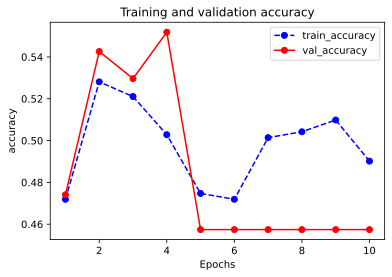

In [32]:
plot_metric(dfhistory,"accuracy")

## predict

In [33]:
#预测概率
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147]])

In [34]:
#预测类别
y_pred = torch.where(y_pred_probs>0.5,
 torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

## save model

### only save weight(recommended)

In [35]:
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [37]:
# 保存模型参数
torch.save(net.state_dict(), "./saved_model/net_parameter.pkl")
net_clone = create_net()
net_clone.load_state_dict(torch.load("./saved_model/net_parameter.pkl"))
net_clone.forward(torch.tensor(x_test[0:10]).float()).data

tensor([[0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147]])

### save whole model(not recommend)

In [39]:
torch.save(net, './saved_model/net_model.pkl')
net_loaded = torch.load('./saved_model/net_model.pkl')
net_loaded(torch.tensor(x_test[0:10]).float()).data

tensor([[0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147],
        [0.5147]])

# CV task example

cifar2分类任务

在Pytorch中构建图片数据管道通常有两种方法。
    
    第一种是使用 torchvision中的datasets.ImageFolder来读取图片然后用 DataLoader来并行加载。
    
    第二种是通过继承 torch.utils.data.Dataset 实现用户自定义读取逻辑然后用 DataLoader来并行加载。
    
    第二种方法是读取用户自定义数据集的通用方法，既可以读取图片数据集，也可以读取文本数据集

## data

In [41]:
# 本篇我们介绍第一种方法
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets

In [42]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_valid = transforms.Compose([transforms.ToTensor()])

In [45]:
ds_train = datasets.ImageFolder("./practice_data/cifar2/train/",transform = transform_train,
                                target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./practice_data/cifar2/test/",transform = transform_train,
                                target_transform= lambda t:torch.tensor([t]).float())
ds_train.class_to_idx

{'airplane': 0, 'automobile': 1}

In [61]:
dl_train = DataLoader(ds_train,batch_size = 4,shuffle = True) # jupyter 中无法使用多线程num_workers
dl_valid = DataLoader(ds_valid,batch_size = 4,shuffle = True)

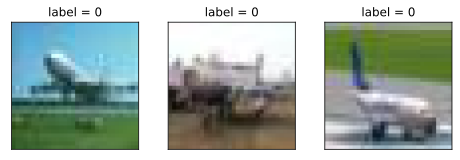

In [60]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#查看部分样本
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
for i in range(3,6):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [62]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height - B C W H
for x,y in dl_train:
    print(x.shape,y.shape)
    break

torch.Size([4, 3, 32, 32]) torch.Size([4, 1])


## model

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module
基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器
(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择通过继承nn.Module基类构建自定义模型。

In [63]:
#测试AdaptiveMaxPool2d的效果
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape

torch.Size([10, 8, 1, 1])

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [65]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

## train

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。
有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。
此处介绍一种较通用的函数形式训练循环。

In [66]:
import pandas as pd
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = torch.nn.BCELoss()
# model.metric_func = lambda y_pred,y_true:roc_auc_score(y_true.data.numpy(),y_pred.data.numpy())
# model.metric_name = "auc"

In [74]:
def train_step(model,features,labels):
    # 训练模式，dropout层发生作用
    model.train()
    # 梯度清零
    model.optimizer.zero_grad()
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
#     metric = model.metric_func(predictions,labels)
    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()
    return loss.item()

def valid_step(model,features,labels):
    # 预测模式，dropout层不发生作用
    model.eval()
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
#     metric = model.metric_func(predictions,labels)
    return loss.item()
# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)

0.6832349300384521

In [75]:
def train_model(model,epochs,dl_train,dl_valid,log_step_freq):
    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name])
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)
    for epoch in range(1,epochs+1): 
        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
#         metric_sum = 0.0
        step = 1
        for step, (features,labels) in enumerate(dl_train, 1):
            loss = train_step(model,features,labels)
            # 打印batch级别日志
            loss_sum += loss
#             metric_sum += metric
            if step%log_step_freq == 0: 
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                        (step, loss_sum/step, metric_sum/step))
        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1
        for val_step, (features,labels) in enumerate(dl_valid, 1):
            val_loss = valid_step(model,features,labels)
            val_loss_sum += val_loss
#             val_metric_sum += val_metric
        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, val_loss_sum/val_step)
        dfhistory.loc[epoch-1] = info
        # 打印epoch级别日志
#         print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
#                 " = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")
#                 %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)
    print('Finished Training...')
    return dfhistory

In [76]:
epochs = 20
dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 50)

Start Training...
================================================================================2021-08-07 17:29:33
[step = 50] loss: 0.694, auc: 1.745
[step = 100] loss: 0.691, auc: 0.873
[step = 150] loss: 0.690, auc: 0.582
[step = 200] loss: 0.689, auc: 0.436
[step = 250] loss: 0.688, auc: 0.349
[step = 300] loss: 0.686, auc: 0.291
[step = 350] loss: 0.685, auc: 0.249
[step = 400] loss: 0.683, auc: 0.218
[step = 450] loss: 0.680, auc: 0.194
[step = 500] loss: 0.679, auc: 0.174
[step = 550] loss: 0.676, auc: 0.159
[step = 600] loss: 0.673, auc: 0.145
[step = 650] loss: 0.671, auc: 0.134
[step = 700] loss: 0.665, auc: 0.125
[step = 750] loss: 0.659, auc: 0.116
[step = 800] loss: 0.655, auc: 0.109
[step = 850] loss: 0.650, auc: 0.103
[step = 900] loss: 0.647, auc: 0.097
[step = 950] loss: 0.642, auc: 0.092
[step = 1000] loss: 0.638, auc: 0.087
[step = 1050] loss: 0.634, auc: 0.083
[step = 1100] loss: 0.633, auc: 0.079
[step = 1150] loss: 0.629, auc: 0.076
[step = 1200] loss: 0.625, a

ValueError: cannot set a row with mismatched columns

## eval

In [77]:
dfhistory

epoch      loss  accuracy  val_loss  val_accuracy
0    1.0  0.756610  0.471910  0.706490      0.474074
1    2.0  0.698051  0.528090  0.688466      0.542593
2    3.0  0.693747  0.521067  0.693335      0.529630
3    4.0  0.694623  0.502809  0.692388      0.551852
4    5.0  0.694241  0.474719  0.694509      0.457407
5    6.0  0.694271  0.471910  0.693580      0.457407
6    7.0  0.693875  0.501404  0.696231      0.457407
7    8.0  0.693326  0.504213  0.693233      0.457407
8    9.0  0.693547  0.509831  0.694276      0.457407
9   10.0  0.693563  0.490169  0.696090      0.457407

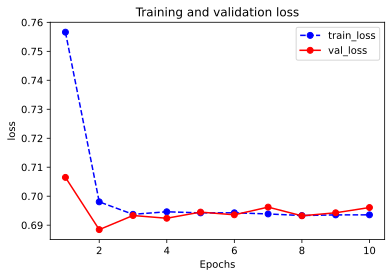

In [78]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(dfhistory,"loss")

## predict

In [79]:
def predict(model,dl):
    model.eval()
    result = torch.cat([model.forward(t[0]) for t in dl])
    return(result.data)

In [80]:
#预测概率
y_pred_probs = predict(model,dl_valid)
y_pred_probs

tensor([[0.7687],
        [0.0632],
        [0.8701],
        ...,
        [0.3420],
        [0.0256],
        [0.7684]])

In [81]:
#预测类别
y_pred = torch.where(y_pred_probs>0.5,
 torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[1.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [1.]])

## save model

In [82]:
model.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])

In [83]:
# 保存模型参数
torch.save(model.state_dict(), "./saved_model/model_parameter.pkl")
net_clone = Net()
net_clone.load_state_dict(torch.load("./saved_model/model_parameter.pkl"))
predict(net_clone,dl_valid)

tensor([[0.2614],
        [0.8766],
        [0.7569],
        ...,
        [0.2206],
        [0.5422],
        [0.6642]])

# NLP task example

文本数据预处理较为繁琐，包括中文切词（本示例不涉及），构建词典，编码转换，序列填充，
构建数据管道等等。

在torch中预处理文本数据一般使用torchtext或者自定义Dataset，torchtext功能非常强大，可以
构建文本分类，序列标注，问答模型，机器翻译等NLP任务的数据集。

下面仅演示使用它来构建文本分类数据集的方法。（torchkeras风格）

torchtext常见API一览

    • torchtext.data.Example : 用来表示一个样本，数据和标签
    • torchtext.vocab.Vocab: 词汇表，可以导入一些预训练词向量
    • torchtext.data.Datasets: 数据集类， __getitem__ 返回 Example实例,
      torchtext.data.TabularDataset是其子类。
    • torchtext.data.Field : 用来定义字段的处理方法（文本字段，标签字段）创建 Example时的预处理，batch 时的一些处理操作。
    • torchtext.data.Iterator: 迭代器，用来生成 batch
    • torchtext.datasets: 包含了常见的数据集

In [103]:
import torchtext

In [ ]:
import torch
import string,re
import torchtext

datapath = "D:/kwCodes/REcodes/re_datasets/chn_senti_corp_情感分析/"
MAX_WORDS = 10000 # 仅考虑最高频的10000个词
MAX_LEN = 200 # 每个样本保留200个词的长度
BATCH_SIZE = 20
#分词方法
tokenizer = lambda x:re.sub('[%s]'%string.punctuation,"",x).split(" ") #过滤掉低频词
def filterLowFreqWords(arr,vocab):
    arr = [[x if x<MAX_WORDS else 0 for x in example] for example in arr]
    return arr

#1,定义各个字段的预处理方法
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer, lower=True,
                            fix_length=MAX_LEN,postprocessing = filterLowFreqWords)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)
#2,构建表格型dataset
#torchtext.data.TabularDataset可读取csv,tsv,json等格式
ds_train, ds_test = torchtext.data.TabularDataset.splits(
    path=datapath, train='train.tsv',test='test.tsv', format='tsv',
    fields=[('label', LABEL), ('text', TEXT)],skip_header = False)
#3,构建词典
TEXT.build_vocab(ds_train)
#4,构建数据管道迭代器
train_iter, test_iter = torchtext.data.Iterator.splits(
    (ds_train, ds_test), sort_within_batch=True,sort_key=lambda x:len(x.text),batch_sizes=(BATCH_SIZE,BATCH_SIZE))

In [ ]:
# 查看数据管道信息
# 注意有坑：text第0维是句子长度
for batch in train_iter:
    features = batch.text
    labels = batch.label
    print(features)
    print(features.shape)
    print(labels)
    break

In [ ]:
# 将数据管道组织成torch.utils.data.DataLoader相似的features,label输出形式
class DataLoader:
    def __init__(self,data_iter):
        self.data_iter = data_iter
        self.length = len(data_iter)
    def __len__(self):
        return self.length
    def __iter__(self):
    # 注意：此处调整features为 batch first，并调整label的shape和dtype
    for batch in self.data_iter:
        yield(torch.transpose(batch.text,0,1),
              torch.unsqueeze(batch.label.float(),dim = 1))
dl_train = DataLoader(train_iter)
dl_test = DataLoader(test_iter)

In [ ]:
import torch
from torch import nn
import torchkeras
torch.random.seed()
class Net(torchkeras.Model):
    '''textCNN'''
    def __init__(self):
        super(Net, self).__init__()
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量
        self.embedding = nn.Embedding(num_embeddings = MAX_WORDS,embedding_dim
        = 3,padding_idx = 1)
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1",nn.Conv1d(in_channels = 3,out_channels =
        16,kernel_size = 5))
        self.conv.add_module("pool_1",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1",nn.ReLU())
        self.conv.add_module("conv_2",nn.Conv1d(in_channels = 16,out_channels
        = 128,kernel_size = 2))
        self.conv.add_module("pool_2",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_2",nn.ReLU())
        self.dense = nn.Sequential()
        self.dense.add_module("flatten",nn.Flatten())
        self.dense.add_module("linear",nn.Linear(6144,1))
        self.dense.add_module("sigmoid",nn.Sigmoid())
    def forward(self,x):
        x = self.embedding(x).transpose(1,2)
        x = self.conv(x)
        y = self.dense(x)
        return y
model = Net()
print(model)
model.summary(input_shape = (200,),input_dtype = torch.LongTensor)

In [ ]:
# 准确率
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32), 
                         torch.zeros_like(y_pred,dtype = torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc
model.compile(loss_func = nn.BCELoss(),optimizer=torch.optim.Adagrad(model.parameters(),lr = 0.02),metrics_dict={"accuracy":accuracy})

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"accuracy")

In [ ]:
# 评估
model.evaluate(dl_test)
model.predict(dl_test)

In [ ]:
# 保存模型参数
torch.save(model.state_dict(), "./data/model_parameter.pkl")
model_clone = Net()
model_clone.load_state_dict(torch.load("./data/model_parameter.pkl"))
model_clone.compile(loss_func = nn.BCELoss(),optimizer=
torch.optim.Adagrad(model.parameters(),lr = 0.02),
 metrics_dict={"accuracy":accuracy})
# 评估模型
model_clone.evaluate(dl_test)

# TimeSeries task example

基于中国2020年3月之前的疫情数据，建立时间序列RNN模型，对中国的新冠肺炎疫情结束
时间进行预测

## data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10, 6))
plt.xticks(rotation=60);
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")
dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

下面我们通过继承torch.utils.data.Dataset实现自定义时间序列数据集。

torch.utils.data.Dataset是一个抽象类，用户想要加载自定义的数据只需要继承这个类，并且覆
写其中的两个方法即可：

    • __len__ :实现len(dataset)返回整个数据集的大小。
    • __getitem__ :用来获取一些索引的数据，使 dataset[i] 返回数据集中第i个样本
不覆写这两个方法会直接返回错误

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader,TensorDataset
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8
class Covid19Dataset(Dataset):
    def __len__(self):
        return len(dfdiff) - WINDOW_SIZE
    def __getitem__(self,i):
        x = dfdiff.loc[i:i+WINDOW_SIZE-1,:]
        feature = torch.tensor(x.values)
        y = dfdiff.loc[i+WINDOW_SIZE,:]
        label = torch.tensor(y.values)
        return (feature,label)
ds_train = Covid19Dataset()
#数据较小，可以将全部训练数据放入到一个batch中，提升性能
dl_train = DataLoader(ds_train,batch_size = 38)

## model

In [ ]:
import torch
from torch import nn
import importlib
import torchkeras
torch.random.seed()
class Block(nn.Module):
    def __init__(self):
        super(Block,self).__init__()
    def forward(self,x,x_input):
        x_out = torch.max((1+x)*x_input[:,-1,:],torch.tensor(0.0))
        return x_out
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3层lstm
        self.lstm = nn.LSTM(input_size = 3,hidden_size = 3,num_layers = 5,batch_first = True)
        self.linear = nn.Linear(3,3)
        self.block = Block()
    def forward(self,x_input):
        x = self.lstm(x_input)[0][:,-1,:]
        x = self.linear(x)
        y = self.block(x,x_input)
        return y
net = Net()
model = torchkeras.Model(net)
print(model)
model.summary(input_shape=(8,3),input_dtype = torch.FloatTensor)

## train

In [ ]:
def mspe(y_pred,y_true):
    err_percent = (y_true - y_pred)**2/ (torch.max(y_true**2,torch.tensor(1e-7)))
    return torch.mean(err_percent)
model.compile(loss_func = mspe,optimizer = torch.optim.Adagrad(model.parameters(),lr = 0.1))

In [ ]:
dfhistory = model.fit(100,dl_train,log_step_freq=10)

## eval

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()
plot_metric(dfhistory,"loss")

## predict

In [ ]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

In [ ]:
#预测此后200天的新增走势,将其结果添加到dfresult中
for i in range(200):
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:,:]),axis=0)
    arr_predict = model.forward(arr_input)
    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(),
    columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

## save model

In [ ]:
print(model.net.state_dict().keys())
# 保存模型参数
torch.save(model.net.state_dict(), "./data/model_parameter.pkl")
net_clone = Net()
net_clone.load_state_dict(torch.load("./data/model_parameter.pkl"))
model_clone = torchkeras.Model(net_clone)
model_clone.compile(loss_func = mspe)
# 评估模型
model_clone.evaluate(dl_train)

# torch_cores

    Pytorch的层次结构从低到高可以分成如下五层。
    最底层为硬件层，Pytorch支持CPU、GPU加入计算资源池。
    第二层为C++实现的内核。
    第三层为Python实现的操作符，提供了封装C++内核的低级API指令，主要包括各种张量操作算子、自动微分、变量管理. 如torch.tensor,torch.cat,torch.autograd.grad,nn.Module. 如果把模型比作一个房子，那么第三层API就是【模型之砖】。
    第四层为Python实现的模型组件，对低级API进行了函数封装，主要包括各种模型层，损失函数，优化器，数据管道等等。 如torch.nn.Linear,torch.nn.BCE,torch.optim.Adam,torch.utils.data.DataLoader. 如果把模型比作一个房子，那么第四层API就是【模型之墙】。
    第五层为Python实现的模型接口。Pytorch没有官方的高阶API。为了便于训练模型，作者仿照keras中的模型接口，使用了不到300行代码，封装了Pytorch的高阶模型接口torchkeras.Model。如果把模型比作一个房子，那么第五层API就是模型本身，即【模型之屋】。

## make tensors

### 数据类型

张量的数据类型和numpy.array基本一一对应，但是不支持str类型。
包括:

    torch.float64(torch.double), 
    torch.float32(torch.float), 
    torch.float16, 
    torch.int64(torch.long), 
    torch.int32(torch.int), 
    torch.int16, 
    torch.int8, 
    torch.uint8, 
    torch.bool
一般神经网络建模使用的都是torch.float32类型

In [106]:
import numpy as np
import torch
# 自动推断数据类型
i = torch.tensor(1);print(i,i.dtype) 
x = torch.tensor(2.0);print(x,x.dtype) 
b = torch.tensor(True);print(b,b.dtype)

tensor(1) torch.int64
tensor(2.) torch.float32
tensor(True) torch.bool


In [107]:
# 指定数据类型
i = torch.tensor(1,dtype = torch.int32);print(i,i.dtype) 
x = torch.tensor(2.0,dtype = torch.double);print(x,x.dtype)

tensor(1, dtype=torch.int32) torch.int32
tensor(2., dtype=torch.float64) torch.float64


In [108]:
# 使用特定类型构造函数
i = torch.IntTensor(1);print(i,i.dtype) 
x = torch.Tensor(np.array(2.0));print(x,x.dtype) #等价于torch.FloatTensor
b = torch.BoolTensor(np.array([1,0,2,0])); print(b,b.dtype)

tensor([16843009], dtype=torch.int32) torch.int32
tensor(2.) torch.float32
tensor([ True, False,  True, False]) torch.bool


In [109]:
# 不同类型进行转换
i = torch.tensor(1); print(i,i.dtype) 
x = i.float(); print(x,x.dtype) #调用 float方法转换成浮点类型
y = i.type(torch.float); print(y,y.dtype) #使用type函数转换成浮点类型
z = i.type_as(x);print(z,z.dtype) #使用type_as方法转换成某个Tensor相同类型

tensor(1) torch.int64
tensor(1.) torch.float32
tensor(1.) torch.float32
tensor(1.) torch.float32


### tensor维度

    不同类型的数据可以用不同维度(dimension)的张量来表示。
    标量为0维张量，向量为1维张量，矩阵为2维张量。
    彩色图像有rgb三个通道，可以表示为3维张量。
    视频还有时间维，可以表示为4维张量。
    可以简单地总结为：有几层中括号，就是多少维的张量。

In [110]:
scalar = torch.tensor(True)
print(scalar)
print(scalar.dim()) # 标量，0维张量

tensor(True)
0


In [111]:
vector = torch.tensor([1.0,2.0,3.0,4.0]) #向量，1维张量
print(vector)
print(vector.dim())

tensor([1., 2., 3., 4.])
1


In [112]:
matrix = torch.tensor([[1.0,2.0],[3.0,4.0]]) #矩阵, 2维张量
print(matrix)
print(matrix.dim())

tensor([[1., 2.],
        [3., 4.]])
2


In [114]:
tensor3 = torch.tensor([[[1.0,2.0],[3.0,4.0]],[[5.0,6.0],[7.0,8.0]]]) # 3维张量
print(tensor3)
print(tensor3.dim())

tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])
3


In [115]:
tensor4 = torch.tensor([[[[1.0,1.0],[2.0,2.0]],[[3.0,3.0],[4.0,4.0]]],
 [[[5.0,5.0],[6.0,6.0]],[[7.0,7.0],[8.0,8.0]]]]) # 4维张量
print(tensor4)
print(tensor4.dim())

tensor([[[[1., 1.],
          [2., 2.]],

         [[3., 3.],
          [4., 4.]]],


        [[[5., 5.],
          [6., 6.]],

         [[7., 7.],
          [8., 8.]]]])
4


### tensor的尺寸

    可以使用 shape属性或者 size()方法查看张量在每一维的长度.
    可以使用view方法改变张量的尺寸。
    如果view方法改变尺寸失败，可以使用reshape方法.

In [121]:
scalar = torch.tensor(True)
print(scalar.size())
print(scalar.shape)

torch.Size([])
torch.Size([])


In [122]:
vector = torch.tensor([1.0,2.0,3.0,4.0])
print(vector.size())
print(vector.shape)

torch.Size([4])
torch.Size([4])


In [124]:
# 使用view可以改变张量尺寸
vector = torch.arange(0,12)
print(vector)
print(vector.shape)

matrix34 = vector.view(3,4)
print(matrix34)
print(matrix34.shape)

matrix43 = vector.view(4,-1) #-1表示该位置长度由程序自动推断
print(matrix43)
print(matrix43.shape)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
torch.Size([12])
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
torch.Size([3, 4])
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])
torch.Size([4, 3])


In [129]:
# 有些操作会让张量存储结构扭曲，直接使用view会失败，可以用reshape方法
matrix26 = torch.arange(0,12).view(2,6)
print(matrix26)
print(matrix26.shape)
# 转置操作让张量存储结构扭曲
matrix62 = matrix26.t()
print(matrix62)
print(matrix62.is_contiguous())
# 直接使用view方法会失败，可以使用reshape方法
# matrix34 = matrix62.view(3,4) #error!
matrix34 = matrix62.reshape(3,4) #等价于matrix34 = matrix62.contiguous().view(3,4)
print(matrix34)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])
torch.Size([2, 6])
tensor([[ 0,  6],
        [ 1,  7],
        [ 2,  8],
        [ 3,  9],
        [ 4, 10],
        [ 5, 11]])
False
tensor([[ 0,  6,  1,  7],
        [ 2,  8,  3,  9],
        [ 4, 10,  5, 11]])


### tensor<->numpy

    可以用numpy方法从Tensor得到numpy数组，也可以用torch.from_numpy从numpy数组得到Tensor。
    这两种方法关联的Tensor和numpy数组是共享数据内存的。
    如果改变其中一个，另外一个的值也会发生改变。
    如果有需要，可以用张量的clone方法拷贝张量，中断这种关联。
    此外，还可以使用item方法从标量张量得到对应的Python数值。
    使用tolist方法从张量得到对应的Python数值列表

In [131]:
import numpy as np
import torch
#直接用torch.tensor将矩阵或者List强行数据类型转换成tensor
arr = np.zeros(3)
tensor = torch.tensor(arr)
print("before add 1:")
print(arr)
print(tensor)
# 强制类型转换的方式，也是切断了关联，是两个不同矩阵
print("\nafter add 1:")
np.add(arr,1, out = arr) #给 arr增加1，ten
print(arr)
print(tensor)

before add 1:
[0. 0. 0.]
tensor([0., 0., 0.], dtype=torch.float64)

after add 1:
[1. 1. 1.]
tensor([0., 0., 0.], dtype=torch.float64)


In [132]:
import numpy as np
import torch
#torch.from_numpy函数从numpy数组得到Tensor
arr = np.zeros(3)
tensor = torch.from_numpy(arr)
print("before add 1:")
print(arr)
print(tensor)

print("\nafter add 1:")
np.add(arr,2, out = arr) #给 arr增加1，tensor也随之改变
print(arr)
print(tensor)

before add 1:
[0. 0. 0.]
tensor([0., 0., 0.], dtype=torch.float64)

after add 1:
[2. 2. 2.]
tensor([2., 2., 2.], dtype=torch.float64)


In [133]:
# numpy方法从Tensor得到numpy数组
tensor = torch.zeros(3)
arr = tensor.numpy()
print("before add 1:")
print(tensor)
print(arr)

print("\nafter add 1:") #使用带下划线的方法表示计算结果会返回给调用 张量
tensor.add_(1) #给 tensor增加1，arr也随之改变
#或： torch.add(tensor,1,out = tensor)
print(tensor)
print(arr)

before add 1:
tensor([0., 0., 0.])
[0. 0. 0.]

after add 1:
tensor([1., 1., 1.])
[1. 1. 1.]


In [134]:
# 可以用clone() 方法拷贝张量，中断这种关联
tensor = torch.zeros(3) #使用clone方法拷贝张量, 拷贝后的张量和原始张量内存独立
arr = tensor.clone().numpy() # 也可以使用tensor.data.numpy()
print("before add 1:")
print(tensor)
print(arr)

print("\nafter add 1:") #使用 带下划线的方法表示计算结果会返回给调用 张量
tensor.add_(1) #给 tensor增加1，arr不再随之改变
print(tensor)
print(arr)

before add 1:
tensor([0., 0., 0.])
[0. 0. 0.]

after add 1:
tensor([1., 1., 1.])
[0. 0. 0.]


In [136]:
# item方法和tolist方法可以将张量转换成Python数值和数值列表
scalar = torch.tensor(1.0) 
s = scalar.item()
print(s)
print(type(s))
tensor = torch.rand(2,2) 
t = tensor.tolist()
print(t)
print(type(t))

1.0
<class 'float'>
[[0.18339228630065918, 0.3863898515701294], [0.5334276556968689, 0.2173824906349182]]
<class 'list'>


## autograde

    神经网络通常依赖反向传播求梯度来更新网络参数，求梯度过程通常是一件非常复杂而容易出错的事情。
    而深度学习框架可以帮助我们自动地完成这种求梯度运算。
    Pytorch一般通过反向传播 backward 方法 实现这种求梯度计算。该方法求得的梯度将存在对应自变量张量的grad属性下。
    除此之外，也能够调用torch.autograd.grad 函数来实现求梯度计算。
    这就是Pytorch的自动微分机制。

### backward

    backward 方法通常在一个标量张量上调用，该方法求得的梯度将存在对应自变量张量的grad属性下。
    如果调用的张量非标量，则要传入一个和它同形状 的gradient参数张量。
    相当于用该gradient参数张量与调用张量作向量点乘，得到的标量结果再反向传播。

####  标量的反向传播

In [137]:
import numpy as np
import torch
# f(x) = a*x**2 + b*x + c的导数
x = torch.tensor(0.0,requires_grad = True) # x需要被求导
a = torch.tensor(1.0) 
b = torch.tensor(-2.0) 
c = torch.tensor(1.0) 
y = a*torch.pow(x,2) + b*x + c 
y.backward()
dy_dx = x.grad
print(dy_dx)

tensor(-2.)


####  非标量的反向传播

In [139]:
import numpy as np
import torch
# f(x) = a*x**2 + b*x + c
x = torch.tensor([[0.0,0.0],[1.0,2.0]],requires_grad = True) # x需要被求导
a = torch.tensor(1.0) 
b = torch.tensor(-2.0) 
c = torch.tensor(1.0) 
y = a*torch.pow(x,2) + b*x + c
gradient = torch.tensor([[1.0,1.0],[1.0,1.0]])
print("x:\n",x)
print("y:\n",y) 
y.backward(gradient = gradient)
x_grad = x.grad
print("x_grad:\n",x_grad)

x:
 tensor([[0., 0.],
        [1., 2.]], requires_grad=True)
y:
 tensor([[1., 1.],
        [0., 1.]], grad_fn=<AddBackward0>)
x_grad:
 tensor([[-2., -2.],
        [ 0.,  2.]])


#### 非标量的反向传播可以用标量的反向传播实现

In [142]:
import numpy as np
import torch
# f(x) = a*x**2 + b*x + c
x = torch.tensor([[0.0,0.0],[1.0,2.0]],requires_grad = True) # x需要被求导
a = torch.tensor(1.0) 
b = torch.tensor(-2.0) 
c = torch.tensor(1.0) 
y = a*torch.pow(x,2) + b*x + c
gradient = torch.tensor([[1.0,1.0],[1.0,1.0]])
z = torch.sum(y*gradient) # 求和构造一个新的loss
print("x:",x)
print("y:",y) 
z.backward()
x_grad = x.grad
print("x_grad:\n",x_grad)

x: tensor([[0., 0.],
        [1., 2.]], requires_grad=True)
y: tensor([[1., 1.],
        [0., 1.]], grad_fn=<AddBackward0>)
x_grad:
 tensor([[-2., -2.],
        [ 0.,  2.]])


### autograde.grad()

In [143]:
import numpy as np
import torch
# f(x) = a*x**2 + b*x + c的导数
x = torch.tensor(0.0,requires_grad = True) # x需要被求导
a = torch.tensor(1.0) 
b = torch.tensor(-2.0) 
c = torch.tensor(1.0) 
y = a*torch.pow(x,2) + b*x + c
# create_graph 设置为 True 将允许创建更高阶的导数
dy_dx = torch.autograd.grad(y,x,create_graph=True)[0]
print(dy_dx.data)
# 求二阶导数
dy2_dx2 = torch.autograd.grad(dy_dx,x)[0]
print(dy2_dx2.data)

tensor(-2.)
tensor(2.)


In [144]:
import numpy as np
import torch
x1 = torch.tensor(1.0,requires_grad = True) # x需要被求导
x2 = torch.tensor(2.0,requires_grad = True)
y1 = x1*x2
y2 = x1+x2
# 允许同时对多个自变量求导数
(dy1_dx1,dy1_dx2) = torch.autograd.grad(outputs=y1,inputs = [x1,x2],retain_graph = True)
print(dy1_dx1,dy1_dx2)
# 如果有多个因变量，相当于把多个因变量的梯度结果求和
(dy12_dx1,dy12_dx2) = torch.autograd.grad(outputs=[y1,y2],inputs = [x1,x2])
print(dy12_dx1,dy12_dx2)

tensor(2.) tensor(1.)
tensor(3.) tensor(2.)


### 利用自动微分和优化器求最小值

In [147]:
# 最优化问题
import numpy as np
import torch
# f(x) = a*x**2 + b*x + c的最小值
x = torch.tensor(0.0,requires_grad = True) # x需要被求导
a = torch.tensor(1.0) 
b = torch.tensor(-2.0) 
c = torch.tensor(1.0)
optimizer = torch.optim.SGD(params=[x],lr = 0.01)

def f(x):
    result = a*torch.pow(x,2) + b*x + c
    return(result)

for i in range(500):
    # 梯度清零
    optimizer.zero_grad()
    # 前向
    y = f(x)
    # 反向
    y.backward()
    # 更新权重
    optimizer.step()
print("y=",f(x).data,";","x=",x.data)
y, f(x), x

y= tensor(0.) ; x= tensor(1.0000)


(tensor(0., grad_fn=<AddBackward0>),
 tensor(0., grad_fn=<AddBackward0>),
 tensor(1.0000, requires_grad=True))

In [153]:
# == 是比较两个对象的内容是否相等，即两个对象的“值“”是否相等
# is 比较的是两个实例对象是不是完全相同，它们是不是同一个对象，占用的内存地址是否相同。即is比较两个条件：1.内容相同。2.内存中地址相同
y == f(x), y is f(x)

(tensor(True), False)

## Computational Graph

### basics

    Pytorch的计算图由节点和边组成，节点表示张量或者Function，边表示张量和Function之间的依赖关系。
    Pytorch中的计算图是动态图。这里的动态主要有两重含义。
    第一层含义是：计算图的正向传播是立即执行的。无需等待完整的计算图创建完毕，每条语句都会在计算图中动态添加节点和边，并立即执行正向传播得到计算结果。
    第二层含义是：计算图在反向传播后立即销毁。下次调用需要重新构建计算图。如果在程序中使用了backward方法执行了反向传播，或者利用torch.autograd.grad方法计算了梯度，那么创建的计算图会被立即销毁，释放存储空间，下次调用需要重新创建。

#### 计算图的正向传播是立即执行的

In [154]:
import torch
w = torch.tensor([[3.0,1.0]],requires_grad=True) 
b = torch.tensor([[3.0]],requires_grad=True) 
X = torch.randn(10,2) 
Y = torch.randn(10,1)
Y_hat = X@w.t() + b # Y_hat定义后其正向传播被立即执行，与其后面的loss创建语句无关
loss = torch.mean(torch.pow(Y_hat-Y,2))
print(loss.data)
print(Y_hat.data)

tensor(34.2999)
tensor([[ 0.1019],
        [ 4.6778],
        [ 9.5230],
        [-0.4467],
        [ 0.4444],
        [10.4677],
        [ 1.3982],
        [ 0.1975],
        [ 6.8244],
        [ 6.1303]])


#### 计算图在反向传播后立即销毁

In [155]:
import torch
w = torch.tensor([[3.0,1.0]],requires_grad=True) 
b = torch.tensor([[3.0]],requires_grad=True) 
X = torch.randn(10,2) 
Y = torch.randn(10,1)
Y_hat = X@w.t() + b # Y_hat定义后其正向传播被立即执行，与其后面的loss创建语句无关
loss = torch.mean(torch.pow(Y_hat-Y,2))
#计算图在反向传播后立即销毁，如果需要保留计算图, 需要设置retain_graph = True
loss.backward() #loss.backward(retain_graph = True) 
#loss.backward() #如果再次执行反向传播将报错

In [156]:
print(loss.data)
print(Y_hat.data)

tensor(29.8692)
tensor([[ 5.7371],
        [ 2.9291],
        [-2.2272],
        [-1.9282],
        [11.6051],
        [ 4.8393],
        [ 1.1596],
        [-0.3427],
        [ 5.1987],
        [ 8.6132]])


### Computational Graph Function

    计算图中的 张量我们已经比较熟悉了, 计算图中的另外一种节点是Function, 实际上就是 Pytorch中各种对张量操作的函数。
    这些Function和我们Python中的函数有一个较大的区别，那就是它同时包括正向计算逻辑和反向传播的逻辑。
    我们可以通过继承torch.autograd.Function来创建这种支持反向传播的Function

In [157]:
class MyReLU(torch.autograd.Function):
 #正向传播逻辑，可以用ctx存储一些值，供反向传播使用。
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    #反向传播逻辑
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

In [158]:
import torch
w = torch.tensor([[3.0,1.0]],requires_grad=True) 
b = torch.tensor([[3.0]],requires_grad=True) 
X = torch.tensor([[-1.0,-1.0],[1.0,1.0]])
Y = torch.tensor([[2.0,3.0]])
relu = MyReLU.apply # relu现在也可以具有正向传播和反向传播功能
Y_hat = relu(X@w.t() + b)
loss = torch.mean(torch.pow(Y_hat-Y,2))
loss.backward()
print(w.grad)
print(b.grad)

tensor([[4.5000, 4.5000]])
tensor([[4.5000]])


In [159]:
# Y_hat的梯度函数即是我们自己所定义的 MyReLU.backward
print(Y_hat.grad_fn)

### Computational Graph and backward

loss.backward()语句调用后，依次发生以下计算过程。
    
    1，loss自己的grad梯度赋值为1，即对自身的梯度为1。 
    2，loss根据其自身梯度以及关联的backward方法，计算出其对应的自变量即y1和y2的梯度，将该值赋值到y1.grad和y2.grad。 
    3，y2和y1根据其自身梯度以及关联的backward方法, 分别计算出其对应的自变量x的梯度，x.grad将其收到的多个梯度值累加。
    （注意，1,2,3步骤的求梯度顺序和对多个梯度值的累加规则恰好是求导链式法则的程序表述）
    正因为求导链式法则衍生的梯度累加规则，张量的grad梯度不会自动清零，在需要的时候需要手动置零。

In [160]:
import torch
x = torch.tensor(3.0,requires_grad=True)
y1 = x + 1
y2 = 2*x
loss = (y1-y2)**2
loss.backward()

### leaf node

    执行下面代码，我们会发现 loss.grad并不是我们期望的1,而是 None。
    类似地 y1.grad 以及 y2.grad也是 None.
    这是为什么呢？这是由于它们不是叶子节点张量。
    在反向传播过程中，只有 is_leaf=True 的叶子节点，需要求导的张量的导数结果才会被最后保留下来。
    那么什么是叶子节点张量呢？叶子节点张量需要满足两个条件。
    1，叶子节点张量是由用户直接创建的张量，而非由某个Function通过计算得到的张量。
    2，叶子节点张量的 requires_grad属性必须为True.
    Pytorch设计这样的规则主要是为了节约内存或者显存空间，因为几乎所有的时候，用户只会关心他自己直接创建的张量的梯度。
    所有依赖于叶子节点张量的张量, 其requires_grad 属性必定是True的，但其梯度值只在计算过程中被用到，不会最终存储到grad属性中。
    如果需要保留中间计算结果的梯度到grad属性中，可以使用 retain_grad方法。 如果仅仅是为了调试代码查看梯度值，可以利用register_hook打印日志。

In [161]:
import torch
x = torch.tensor(3.0,requires_grad=True)
y1 = x + 1
y2 = 2*x
loss = (y1-y2)**2
loss.backward()
print("loss.grad:", loss.grad)
print("y1.grad:", y1.grad)
print("y2.grad:", y2.grad)
print(x.grad)

loss.grad: None
y1.grad: None
y2.grad: None
tensor(4.)


D:\Anaconda\envs\Deep\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  import sys
D:\Anaconda\envs\Deep\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  
D:\Anaconda\envs\Deep\lib\site

In [162]:
print(x.is_leaf)
print(y1.is_leaf)
print(y2.is_leaf)
print(loss.is_leaf)

True
False
False
False


利用retain_grad可以保留非叶子节点的梯度值，利用register_hook可以查看非叶子节点的梯度
值。

In [163]:
import torch
#正向传播
x = torch.tensor(3.0,requires_grad=True)
y1 = x + 1
y2 = 2*x
loss = (y1-y2)**2 #非叶子节点梯度显示控制
y1.register_hook(lambda grad: print('y1 grad: ', grad))
y2.register_hook(lambda grad: print('y2 grad: ', grad))
loss.retain_grad()
#反向传播
loss.backward()
print("loss.grad:", loss.grad)
print("x.grad:", x.grad)

y2 grad:  tensor(4.)
y1 grad:  tensor(-4.)
loss.grad: tensor(1.)
x.grad: tensor(4.)


### 计算图在TensorBoard中的可视化

可以利用 torch.utils.tensorboard 将计算图导出到 TensorBoard进行可视化。

In [169]:
from torch import nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.w = nn.Parameter(torch.randn(2,1))
        self.b = nn.Parameter(torch.zeros(1,1))
    def forward(self, x):
        y = x@self.w + self.b
        return y
net = Net()

In [170]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./tensorboard')
writer.add_graph(net,input_to_model = torch.rand(10,2))
writer.close()

In [172]:
# %reload_ext tensorboard
%load_ext tensorboard
#%tensorboard --logdir ./data/tensorboard

In [173]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./data/tensorboard (started 0:01:59 ago; pid 3312)


In [174]:
#在tensorboard中查看模型
notebook.start("--logdir ./tensorboard")

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 33752.

# torch的三阶API使用思想

## 低阶API - 仅利用torch的tensor, nn, autograde等基本工具来搭建Deep Learning

### Linear Regression example

#### data

In [175]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
#样本数量
n = 400
# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0 #torch.rand是均匀分布
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1]) # @表示矩阵乘法,增加正态扰动

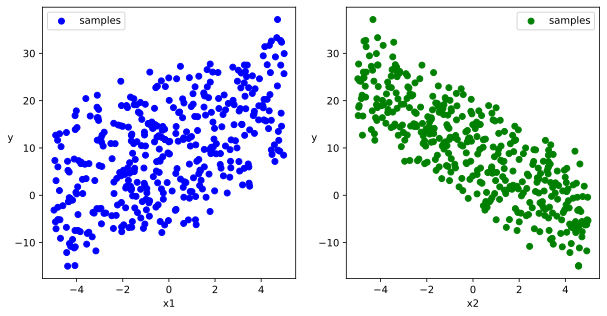

In [179]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

#### dataloader(iter)

In [180]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices) #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)
# 测试数据管道效果 
batch_size = 4
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tensor([[-4.0590,  3.8674],
        [-3.0212, -1.1471],
        [-1.7026, -0.2982],
        [ 3.0944, -1.3004]])
tensor([[-10.9078],
        [  6.2753],
        [  6.8742],
        [ 18.3188]])


#### model

In [181]:
# 定义模型
class LinearRegression:
    def __init__(self):
        self.w = torch.randn_like(w0,requires_grad=True)
        self.b = torch.zeros_like(b0,requires_grad=True)
    #正向传播
    def forward(self,x):
        return x@self.w + self.b
    # 损失函数
    def loss_func(self,y_pred,y_true): 
        return torch.mean((y_pred - y_true)**2/2)
model = LinearRegression()

#### train

In [183]:
def train_step(model, features, labels):
    predictions = model.forward(features)
    loss = model.loss_func(predictions,labels)
    # 反向传播求梯度
    loss.backward()
    # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录
    with torch.no_grad():
        # 梯度下降法更新参数
        model.w -= 0.001*model.w.grad
        model.b -= 0.001*model.b.grad
        # 梯度清零
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss

In [184]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

tensor(184.4571, grad_fn=<MeanBackward0>)

In [185]:
import datetime
#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)
        if epoch%200==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss.item())
            print("model.w =",model.w.data)
            print("model.b =",model.b.data)
train_model(model,epochs = 1000)


================================================================================2021-08-08 13:54:51
epoch = 200 loss =  2.9255740642547607
model.w = tensor([[ 2.0107],
        [-2.9556]])
model.b = tensor([[9.7900]])

================================================================================2021-08-08 13:54:53
epoch = 400 loss =  1.4426850080490112
model.w = tensor([[ 2.0124],
        [-2.9552]])
model.b = tensor([[9.7934]])

================================================================================2021-08-08 13:54:56
epoch = 600 loss =  1.3299027681350708
model.w = tensor([[ 2.0102],
        [-2.9564]])
model.b = tensor([[9.7931]])

================================================================================2021-08-08 13:54:58
epoch = 800 loss =  2.3252437114715576
model.w = tensor([[ 2.0110],
        [-2.9554]])
model.b = tensor([[9.7930]])

================================================================================2021-08-08 13:55:00
epoch = 1000 loss =  2.2918

#### evaluate

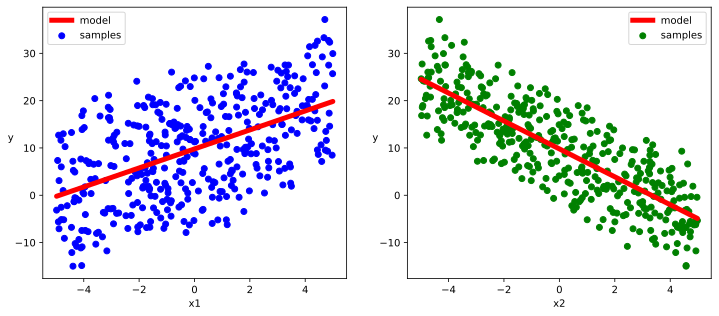

In [187]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.plot(X[:,0].numpy(),(model.w[0].data*X[:,0]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.plot(X[:,1].numpy(),(model.w[1].data*X[:,1]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

### MLP classification example

#### data

In [189]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#正负样本数量
n_positive,n_negative = 2000,2000
#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1])
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p) 
#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1])
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n) 
#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0) 
#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

#### dataloader

In [190]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices) #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)
# 测试数据管道效果 
batch_size = 4
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tensor([[-3.0181,  4.5259],
        [ 6.5072, -6.9682],
        [ 8.5986, -1.3502],
        [ 1.7050,  9.5535]])
tensor([[1.],
        [0.],
        [0.],
        [0.]])


#### model

In [191]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2,4))
        self.b1 = nn.Parameter(torch.zeros(1,4))
        self.w2 = nn.Parameter(torch.randn(4,8))
        self.b2 = nn.Parameter(torch.zeros(1,8))
        self.w3 = nn.Parameter(torch.randn(8,1))
        self.b3 = nn.Parameter(torch.zeros(1,1))
    # 正向传播
    def forward(self,x):
        x = torch.relu(x@self.w1 + self.b1)
        x = torch.relu(x@self.w2 + self.b2)
        y = torch.sigmoid(x@self.w3 + self.b3)
        return y
    # 损失函数(二元交叉熵)
    def loss_func(self,y_pred,y_true): 
        #将预测值限制在1e-7以上, 1- (1e-7)以下，避免log(0)错误
        eps = 1e-7
        y_pred = torch.clamp(y_pred,eps,1.0-eps)
        bce = - y_true*torch.log(y_pred) - (1-y_true)*torch.log(1-y_pred)
        return torch.mean(bce)
    # 评估指标(准确率)
    def metric_func(self,y_pred,y_true):
        y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                             torch.zeros_like(y_pred,dtype = torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
model = DNNModel()

In [192]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

print("init loss:", loss.item())
print("init metric:", metric.item())

init loss: 8.757306098937988
init metric: 0.4506903290748596


In [193]:
len(list(model.parameters()))

6

#### train

In [197]:
def train_step(model, features, labels): 
    # 正向传播求损失
    predictions = model.forward(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
    
    # 反向传播求梯度
    loss.backward()
    # 梯度下降法更新参数
    for param in model.parameters():
        #注意是对param.data进行重新赋值,避免此处操作引起梯度记录
        param.data = (param.data - 0.01*param.grad.data)
    # 梯度清零
    model.zero_grad()
        
    return loss.item(),metric.item()
    
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in data_iter(X,Y,20):
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)
        
        if epoch%100==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)
            
train_model(model,epochs = 300)


================================================================================2021-08-08 14:06:37
epoch = 100 loss =  0.1790155761037022 metric =  0.9317499923706055

================================================================================2021-08-08 14:07:02
epoch = 200 loss =  0.17554876335896552 metric =  0.9329999920725822

================================================================================2021-08-08 14:07:25
epoch = 300 loss =  0.17502431702334434 metric =  0.9332499933242798


#### evaluate

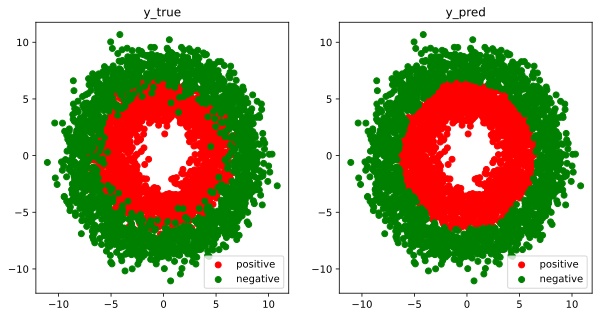

In [199]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (10,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");
Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]
ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

### tensor operations

    张量的操作主要包括张量的结构操作和张量的数学运算。
    张量结构操作诸如：张量创建，索引切片，维度变换，合并分割。
    张量数学运算主要有：标量运算，向量运算，矩阵运算。另外我们会介绍张量运算的广播机制。

#### making tensor

In [249]:
# 张量创建的许多方法和numpy中创建array的方法很像
import numpy as np
import torch

In [250]:
a = torch.tensor([1,2,3],dtype = torch.float)
print(a)

tensor([1., 2., 3.])


In [251]:
b = torch.arange(1,10,step = 2)
print(b)

tensor([1, 3, 5, 7, 9])


In [252]:
c = torch.linspace(0.0,2*3.14,10)
print(c)

tensor([0.0000, 0.6978, 1.3956, 2.0933, 2.7911, 3.4889, 4.1867, 4.8844, 5.5822,
        6.2800])


In [253]:
d = torch.zeros((3,3))
print(d)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [255]:
a = torch.ones((3,3),dtype = torch.int)
b = torch.zeros_like(a,dtype = torch.float)
print(a)
print(b)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=torch.int32)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [256]:
torch.fill_(b,5)
print(b)

tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]])


In [257]:
#均匀随机分布
torch.manual_seed(0)
minval,maxval = 0,10
a = minval + (maxval-minval)*torch.rand([5])
print(a)

tensor([4.9626, 7.6822, 0.8848, 1.3203, 3.0742])


In [258]:
#正态分布随机
b = torch.normal(mean = torch.zeros(3,3), std = torch.ones(3,3))
print(b)

tensor([[ 0.5507,  0.2704,  0.6472],
        [ 0.2490, -0.3354,  0.4564],
        [-0.6255,  0.4539, -1.3740]])


In [261]:
#正态分布随机
mean,std = 2,5
c = std*torch.randn((3,3))+mean
print(c)

tensor([[16.2371,  6.6990,  5.8742],
        [ 2.9593,  8.3190, -4.4522],
        [-1.9555,  1.8956, -1.5924]])


In [260]:
#整数随机排列
d = torch.randperm(20)
print(d)

tensor([ 1, 11, 19, 14, 12,  6,  5,  9,  8, 18, 15,  4,  2,  3,  7, 13,  0, 10,
        16, 17])


In [263]:
#特殊矩阵
I = torch.eye(3,3) #单位矩阵
print(I)
t = torch.diag(torch.tensor([1,2,3])) #对角矩阵
print(t)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[1, 0, 0],
        [0, 2, 0],
        [0, 0, 3]])


#### slicing tensor

    张量的索引切片方式和numpy几乎是一样的。切片时支持缺省参数和省略号。
    可以通过索引和切片对部分元素进行修改。
    此外，对于不规则的切片提取,可以使用torch.index_select, torch.masked_select, torch.take
    如果要通过修改张量的某些元素得到新的张量，可使用torch.where,torch.masked_fill,torch.index_fill

In [264]:
#均匀随机分布
torch.manual_seed(0)
minval,maxval = 0,10
t = torch.floor(minval + (maxval-minval)*torch.rand([5,5])).int()
print(t)

tensor([[4, 7, 0, 1, 3],
        [6, 4, 8, 4, 6],
        [3, 4, 0, 1, 2],
        [5, 6, 8, 1, 2],
        [6, 9, 3, 8, 4]], dtype=torch.int32)


In [265]:
# 第0行
print(t[0])

tensor([4, 7, 0, 1, 3], dtype=torch.int32)


In [266]:
#倒数第一行
print(t[-1])

tensor([6, 9, 3, 8, 4], dtype=torch.int32)


In [267]:
#第1行第3列
print(t[1,3])
print(t[1][3])

tensor(4, dtype=torch.int32)
tensor(4, dtype=torch.int32)


In [268]:
#第1行至第3行
print(t[1:4,:])

tensor([[6, 4, 8, 4, 6],
        [3, 4, 0, 1, 2],
        [5, 6, 8, 1, 2]], dtype=torch.int32)


In [269]:
#第1行至最后一行，第0列到最后一列每隔两列取一列
print(t[1:4,:4:2])

tensor([[6, 8],
        [3, 0],
        [5, 8]], dtype=torch.int32)


In [271]:
#可以使用索引和切片修改部分元素
x = torch.tensor([[1,2],[3,4]],dtype = torch.float32,requires_grad=True)
x.data[1,:] = torch.tensor([0.0,0.0])
x

tensor([[1., 2.],
        [0., 0.]], requires_grad=True)

In [272]:
a = torch.arange(27).view(3,3,3)
print(a)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]])


In [273]:
#省略号可以表示多个冒号
print(a[...,1])

tensor([[ 1,  4,  7],
        [10, 13, 16],
        [19, 22, 25]])


以上切片方式相对规则，对于不规则的切片提取,可以使用torch.index_select, torch.take,torch.gather, torch.masked_select.

考虑班级成绩册的例子，有4个班级，每个班级10个学生，每个学生7门科目成绩。可以用一个4×10×7的张量来表示。

In [274]:
minval=0
maxval=100
scores = torch.floor(minval + (maxval-minval)*torch.rand([4,10,7])).int()
print(scores)

tensor([[[55, 95,  3, 18, 37, 30, 93],
         [17, 26, 15,  3, 20, 92, 72],
         [74, 52, 24, 58,  3, 13, 24],
         [81, 79, 27, 48, 81, 99, 69],
         [56, 83, 20, 59, 11, 15, 24],
         [72, 70, 20, 65, 77, 43, 51],
         [61, 81, 98, 11, 31, 69, 91],
         [93, 94, 59,  6, 54, 18,  3],
         [94, 88,  0, 59, 41, 41, 27],
         [69, 20, 68, 75, 85, 68,  0]],

        [[17, 74, 60, 10, 21, 97, 83],
         [28, 37,  2, 49, 12, 11, 47],
         [57, 29, 79, 19, 95, 84,  7],
         [37, 52, 57, 61, 69, 52, 25],
         [73,  2, 20, 37, 25, 32,  9],
         [39, 60, 17, 47, 85, 44, 51],
         [45, 60, 81, 97, 81, 97, 46],
         [ 5, 26, 84, 49, 25, 11,  3],
         [ 7, 39, 77, 77,  1, 81, 10],
         [39, 29, 40, 40,  5,  6, 42]],

        [[50, 27, 68,  4, 46, 93, 29],
         [95, 68,  4, 81, 44, 27, 89],
         [ 9, 55, 39, 85, 63, 74, 67],
         [37, 39,  8, 77, 89, 84, 14],
         [52, 14, 22, 20, 67, 20, 48],
         [52, 82, 12,

In [275]:
#抽取每个班级第0个学生，第5个学生，第9个学生的全部成绩
torch.index_select(scores,dim = 1,index = torch.tensor([0,5,9]))

tensor([[[55, 95,  3, 18, 37, 30, 93],
         [72, 70, 20, 65, 77, 43, 51],
         [69, 20, 68, 75, 85, 68,  0]],

        [[17, 74, 60, 10, 21, 97, 83],
         [39, 60, 17, 47, 85, 44, 51],
         [39, 29, 40, 40,  5,  6, 42]],

        [[50, 27, 68,  4, 46, 93, 29],
         [52, 82, 12, 15, 20, 84, 32],
         [33, 42, 50, 91, 56, 94, 80]],

        [[18, 72, 14, 28, 64, 66, 87],
         [26, 26,  2, 60, 21,  5, 93],
         [70, 33, 25, 58, 24, 61, 59]]], dtype=torch.int32)

In [276]:
#抽取每个班级第0个学生，第5个学生，第9个学生的第1门课程，第3门课程，第6门课程成绩
q = torch.index_select(torch.index_select(scores,dim = 1,index =
                                          torch.tensor([0,5,9])),dim=2,index = torch.tensor([1,3,6]))
print(q)

tensor([[[95, 18, 93],
         [70, 65, 51],
         [20, 75,  0]],

        [[74, 10, 83],
         [60, 47, 51],
         [29, 40, 42]],

        [[27,  4, 29],
         [82, 15, 32],
         [42, 91, 80]],

        [[72, 28, 87],
         [26, 60, 93],
         [33, 58, 59]]], dtype=torch.int32)


In [277]:
#抽取第0个班级第0个学生的第0门课程，第2个班级的第4个学生的第1门课程，第3个班级的第9个学生第6门课程成绩
#take将输入看成一维数组，输出和index同形状
s = torch.take(scores,torch.tensor([0*10*7+0,2*10*7+4*7+1,3*10*7+9*7+6]))
s

tensor([55, 14, 59], dtype=torch.int32)

以上这些方法仅能提取张量的部分元素值，但不能更改张量的部分元素值得到新的张量。
如果要通过修改张量的部分元素值得到新的张量，可以使用torch.where,torch.index_fill 和torch.masked_fill
    
    torch.where可以理解为if的张量版本。
    torch.index_fill的选取元素逻辑和torch.index_select相同。
    torch.masked_fill的选取元素逻辑和torch.masked_select相同。

In [278]:
#如果分数大于60分，赋值成1，否则赋值成0
ifpass = torch.where(scores>60,torch.tensor(1),torch.tensor(0))
print(ifpass)

tensor([[[0, 1, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 1, 1],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 1, 1, 1],
         [0, 1, 0, 0, 0, 0, 0],
         [1, 1, 0, 1, 1, 0, 0],
         [1, 1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0],
         [1, 0, 1, 1, 1, 1, 0]],

        [[0, 1, 0, 0, 0, 1, 1],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 1, 1, 0],
         [0, 0, 0, 1, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 1, 1, 1, 1, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 1, 1, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 1, 0],
         [1, 1, 0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 1, 1, 1, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 1, 0],
         [1, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [1, 1, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 1, 1]],

        [[0, 1, 0, 0, 1, 1, 1],
  

In [279]:
#将每个班级第0个学生，第5个学生，第9个学生的全部成绩赋值成满分
torch.index_fill(scores,dim = 1,index = torch.tensor([0,5,9]),value = 100) 
#等价于 scores.index_fill(dim = 1,index = torch.tensor([0,5,9]),value = 100)

tensor([[[100, 100, 100, 100, 100, 100, 100],
         [ 17,  26,  15,   3,  20,  92,  72],
         [ 74,  52,  24,  58,   3,  13,  24],
         [ 81,  79,  27,  48,  81,  99,  69],
         [ 56,  83,  20,  59,  11,  15,  24],
         [100, 100, 100, 100, 100, 100, 100],
         [ 61,  81,  98,  11,  31,  69,  91],
         [ 93,  94,  59,   6,  54,  18,   3],
         [ 94,  88,   0,  59,  41,  41,  27],
         [100, 100, 100, 100, 100, 100, 100]],

        [[100, 100, 100, 100, 100, 100, 100],
         [ 28,  37,   2,  49,  12,  11,  47],
         [ 57,  29,  79,  19,  95,  84,   7],
         [ 37,  52,  57,  61,  69,  52,  25],
         [ 73,   2,  20,  37,  25,  32,   9],
         [100, 100, 100, 100, 100, 100, 100],
         [ 45,  60,  81,  97,  81,  97,  46],
         [  5,  26,  84,  49,  25,  11,   3],
         [  7,  39,  77,  77,   1,  81,  10],
         [100, 100, 100, 100, 100, 100, 100]],

        [[100, 100, 100, 100, 100, 100, 100],
         [ 95,  68,   4,  81, 

In [280]:
#将分数小于60分的分数赋值成60分 
b = torch.masked_fill(scores,scores<60,60) 
#等价于b = scores.masked_fill(scores<60,60)
b

tensor([[[60, 95, 60, 60, 60, 60, 93],
         [60, 60, 60, 60, 60, 92, 72],
         [74, 60, 60, 60, 60, 60, 60],
         [81, 79, 60, 60, 81, 99, 69],
         [60, 83, 60, 60, 60, 60, 60],
         [72, 70, 60, 65, 77, 60, 60],
         [61, 81, 98, 60, 60, 69, 91],
         [93, 94, 60, 60, 60, 60, 60],
         [94, 88, 60, 60, 60, 60, 60],
         [69, 60, 68, 75, 85, 68, 60]],

        [[60, 74, 60, 60, 60, 97, 83],
         [60, 60, 60, 60, 60, 60, 60],
         [60, 60, 79, 60, 95, 84, 60],
         [60, 60, 60, 61, 69, 60, 60],
         [73, 60, 60, 60, 60, 60, 60],
         [60, 60, 60, 60, 85, 60, 60],
         [60, 60, 81, 97, 81, 97, 60],
         [60, 60, 84, 60, 60, 60, 60],
         [60, 60, 77, 77, 60, 81, 60],
         [60, 60, 60, 60, 60, 60, 60]],

        [[60, 60, 68, 60, 60, 93, 60],
         [95, 68, 60, 81, 60, 60, 89],
         [60, 60, 60, 85, 63, 74, 67],
         [60, 60, 60, 77, 89, 84, 60],
         [60, 60, 60, 60, 67, 60, 60],
         [60, 82, 60,

#### dimension change

维度变换相关函数主要有 torch.reshape(或者调用张量的view方法), torch.squeeze, torch.unsqueeze, torch.transpose

    torch.reshape 可以改变张量的形状。
    torch.squeeze 可以减少维度。
    torch.unsqueeze 可以增加维度。
    torch.transpose 可以交换维度。

In [281]:
# 张量的view方法有时候会调用失败，可以使用reshape方法。
torch.manual_seed(0)
minval,maxval = 0,255
a = (minval + (maxval-minval)*torch.rand([1,3,3,2])).int()
print(a.shape)
print(a)

torch.Size([1, 3, 3, 2])
tensor([[[[126, 195],
          [ 22,  33],
          [ 78, 161]],

         [[124, 228],
          [116, 161],
          [ 88, 102]],

         [[  5,  43],
          [ 74, 132],
          [177, 204]]]], dtype=torch.int32)


In [282]:
# 改成 （3,6）形状的张量
b = a.view([3,6]) #torch.reshape(a,[3,6])
print(b.shape)
print(b)

torch.Size([3, 6])
tensor([[126, 195,  22,  33,  78, 161],
        [124, 228, 116, 161,  88, 102],
        [  5,  43,  74, 132, 177, 204]], dtype=torch.int32)


In [283]:
# 改回成 [1,3,3,2] 形状的张量
c = torch.reshape(b,[1,3,3,2]) # b.view([1,3,3,2]) 
print(c)

tensor([[[[126, 195],
          [ 22,  33],
          [ 78, 161]],

         [[124, 228],
          [116, 161],
          [ 88, 102]],

         [[  5,  43],
          [ 74, 132],
          [177, 204]]]], dtype=torch.int32)


如果张量在某个维度上只有一个元素，利用torch.squeeze可以消除这个维度。

torch.unsqueeze的作用和torch.squeeze的作用相反。

In [284]:
a = torch.tensor([[1.0,2.0]])
s = torch.squeeze(a)
print(a)
print(s)
print(a.shape)
print(s.shape)

tensor([[1., 2.]])
tensor([1., 2.])
torch.Size([1, 2])
torch.Size([2])


In [285]:
#在第0维插入长度为1的一个维度
d = torch.unsqueeze(s,axis=0)
print(s)
print(d)
print(s.shape)
print(d.shape)

tensor([1., 2.])
tensor([[1., 2.]])
torch.Size([2])
torch.Size([1, 2])


torch.transpose可以交换张量的维度，torch.transpose常用于图片存储格式的变换上。

如果是二维的矩阵，通常会调用矩阵的转置方法 matrix.t()，等价于 torch.transpose(matrix,0,1)。

In [286]:
minval=0
maxval=255
# Batch,Height,Width,Channel
data = torch.floor(minval + (maxval-minval)*torch.rand([100,256,256,4])).int()
print(data.shape)
# 转换成 Pytorch默认的图片格式 Batch,Channel,Height,Width 
# 需要交换两次
data_t = torch.transpose(torch.transpose(data,1,2),1,3)
print(data_t.shape)

torch.Size([100, 256, 256, 4])
torch.Size([100, 4, 256, 256])


In [287]:
matrix = torch.tensor([[1,2,3],[4,5,6]])
print(matrix)
print(matrix.t()) #等价于torch.transpose(matrix,0,1)

tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[1, 4],
        [2, 5],
        [3, 6]])


#### concate and split

可以用torch.cat方法和torch.stack方法将多个张量合并，可以用torch.split方法把一个张量分割
成多个张量。

torch.cat和torch.stack有略微的区别，torch.cat是连接，不会增加维度，而torch.stack是堆叠，
会增加维度。

In [288]:
# cat类似于list.extend
a = torch.tensor([[1.0,2.0],[3.0,4.0]])
b = torch.tensor([[5.0,6.0],[7.0,8.0]])
c = torch.tensor([[9.0,10.0],[11.0,12.0]])
abc_cat = torch.cat([a,b,c],dim = 0)
print(abc_cat.shape)
print(abc_cat)

torch.Size([6, 2])
tensor([[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [11., 12.]])


In [289]:
# stack类似于list.append
abc_stack = torch.stack([a,b,c],axis = 0) #torch中dim和axis参数名可以混用
print(abc_stack.shape)
print(abc_stack)

torch.Size([3, 2, 2])
tensor([[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 9., 10.],
         [11., 12.]]])


In [290]:
torch.cat([a,b,c],axis = 1)

tensor([[ 1.,  2.,  5.,  6.,  9., 10.],
        [ 3.,  4.,  7.,  8., 11., 12.]])

In [291]:
torch.stack([a,b,c],axis = 1)

tensor([[[ 1.,  2.],
         [ 5.,  6.],
         [ 9., 10.]],

        [[ 3.,  4.],
         [ 7.,  8.],
         [11., 12.]]])

torch.split是torch.cat的逆运算，可以指定分割份数平均分割，也可以通过指定每份的记录数量进行分割。

In [293]:
print(abc_cat)
a,b,c = torch.split(abc_cat,split_size_or_sections = 2,dim = 0) #每份2个进行分割
print(a)
print(b)
print(c)

tensor([[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [11., 12.]])
tensor([[1., 2.],
        [3., 4.]])
tensor([[5., 6.],
        [7., 8.]])
tensor([[ 9., 10.],
        [11., 12.]])


In [295]:
print(abc_cat)
p,q,r = torch.split(abc_cat,split_size_or_sections =[4,1,1],dim = 0) #每份分别为[4,1,1]
print(p)
print(q)
print(r)

tensor([[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [11., 12.]])
tensor([[1., 2.],
        [3., 4.],
        [5., 6.],
        [7., 8.]])
tensor([[ 9., 10.]])
tensor([[11., 12.]])


#### scalar operations

    张量的数学运算符可以分为标量运算符、向量运算符、以及矩阵运算符。
    加减乘除乘方，以及三角函数，指数，对数等常见函数，逻辑比较运算符等都是标量运算符。
    标量运算符的特点是对张量实施逐元素运算。
    有些标量运算符对常用的数学运算符进行了重载。并且支持类似numpy的广播特性。

In [296]:
import torch
import numpy as np

In [297]:
a = torch.tensor([[1.0,2],[-3,4.0]])
b = torch.tensor([[5.0,6],[7.0,8.0]])
a+b #运算符重载

tensor([[ 6.,  8.],
        [ 4., 12.]])

In [298]:
a-b

tensor([[ -4.,  -4.],
        [-10.,  -4.]])

In [299]:
a*b

tensor([[  5.,  12.],
        [-21.,  32.]])

In [300]:
a/b

tensor([[ 0.2000,  0.3333],
        [-0.4286,  0.5000]])

In [301]:
a**2

tensor([[ 1.,  4.],
        [ 9., 16.]])

In [302]:
a**(0.5)

tensor([[1.0000, 1.4142],
        [   nan, 2.0000]])

In [303]:
a%3 #求模

tensor([[1., 2.],
        [-0., 1.]])

In [304]:
a//3 #地板除法

tensor([[ 0.,  0.],
        [-1.,  1.]])

In [305]:
a>=2 # torch.ge(a,2) #ge: greater_equal缩写

tensor([[False,  True],
        [False,  True]])

In [306]:
(a>=2)&(a<=3)

tensor([[False,  True],
        [False, False]])

In [307]:
(a>=2)|(a<=3)

tensor([[True, True],
        [True, True]])

In [308]:
a==5 #torch.eq(a,5)

tensor([[False, False],
        [False, False]])

In [309]:
torch.sqrt(a)

tensor([[1.0000, 1.4142],
        [   nan, 2.0000]])

In [310]:
a = torch.tensor([1.0,8.0])
b = torch.tensor([5.0,6.0])
c = torch.tensor([6.0,7.0])
d = a+b+c
print(d)

tensor([12., 21.])


In [311]:
print(torch.max(a,b))

tensor([5., 8.])


In [312]:
print(torch.min(a,b))

tensor([1., 6.])


In [313]:
x = torch.tensor([2.6,-2.7])
print(torch.round(x)) #保留整数部分，四舍五入
print(torch.floor(x)) #保留整数部分，向下归整
print(torch.ceil(x)) #保留整数部分，向上归整
print(torch.trunc(x)) #保留整数部分，向0归整

tensor([ 3., -3.])
tensor([ 2., -3.])
tensor([ 3., -2.])
tensor([ 2., -2.])


In [314]:
x = torch.tensor([2.6,-2.7])
print(torch.fmod(x,2)) #作除法取余数
print(torch.remainder(x,2)) #作除法取剩余的部分，结果恒正

tensor([ 0.6000, -0.7000])
tensor([0.6000, 1.3000])


In [316]:
# 幅值裁剪
x = torch.tensor([0.9,-0.8,100.0,-20.0,0.7])
y = torch.clamp(x,min=-1,max = 1)
z = torch.clamp(x,max = 1)
print(y)
print(z)

tensor([ 0.9000, -0.8000,  1.0000, -1.0000,  0.7000])
tensor([  0.9000,  -0.8000,   1.0000, -20.0000,   0.7000])


#### vector operations

向量运算符只在一个特定轴上运算，将一个向量映射到一个标量或者另外一个向量。

In [317]:
#统计值
a = torch.arange(1,10).float()
print(torch.sum(a))
print(torch.mean(a))
print(torch.max(a))
print(torch.min(a))
print(torch.prod(a)) #累乘
print(torch.std(a)) #标准差
print(torch.var(a)) #方差
print(torch.median(a)) #中位数

tensor(45.)
tensor(5.)
tensor(9.)
tensor(1.)
tensor(362880.)
tensor(2.7386)
tensor(7.5000)
tensor(5.)


In [318]:
#指定维度计算统计值
b = a.view(3,3)
print(b)
print(torch.max(b,dim = 0))
print(torch.max(b,dim = 1))

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
torch.return_types.max(
values=tensor([7., 8., 9.]),
indices=tensor([2, 2, 2]))
torch.return_types.max(
values=tensor([3., 6., 9.]),
indices=tensor([2, 2, 2]))


In [319]:
#cum扫描
a = torch.arange(1,10)
print(torch.cumsum(a,0))
print(torch.cumprod(a,0))
print(torch.cummax(a,0).values)
print(torch.cummax(a,0).indices)
print(torch.cummin(a,0))

tensor([ 1,  3,  6, 10, 15, 21, 28, 36, 45])
tensor([     1,      2,      6,     24,    120,    720,   5040,  40320, 362880])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
torch.return_types.cummin(
values=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [320]:
#torch.sort和torch.topk可以对张量排序
a = torch.tensor([[9,7,8],[1,3,2],[5,6,4]]).float()
print(torch.topk(a,2,dim = 0),"\n")
print(torch.topk(a,2,dim = 1),"\n")
print(torch.sort(a,dim = 1),"\n") #利用torch.topk可以在Pytorch中实现KNN算法

torch.return_types.topk(
values=tensor([[9., 7., 8.],
        [5., 6., 4.]]),
indices=tensor([[0, 0, 0],
        [2, 2, 2]])) 

torch.return_types.topk(
values=tensor([[9., 8.],
        [3., 2.],
        [6., 5.]]),
indices=tensor([[0, 2],
        [1, 2],
        [1, 0]])) 

torch.return_types.sort(
values=tensor([[7., 8., 9.],
        [1., 2., 3.],
        [4., 5., 6.]]),
indices=tensor([[1, 2, 0],
        [0, 2, 1],
        [2, 0, 1]])) 



#### matrix operations

矩阵必须是二维的。类似torch.tensor([1,2,3])这样的不是矩阵。

矩阵运算包括：矩阵乘法，矩阵转置，矩阵逆，矩阵求迹，矩阵范数，矩阵行列式，矩阵求特征
值，矩阵分解等运算

In [321]:
#矩阵乘法
a = torch.tensor([[1,2],[3,4]])
b = torch.tensor([[2,0],[0,2]])
print(a@b) #等价于torch.matmul(a,b) 或 torch.mm(a,b)

tensor([[2, 4],
        [6, 8]])


In [322]:
#矩阵转置
a = torch.tensor([[1.0,2],[3,4]])
print(a.t())

tensor([[1., 3.],
        [2., 4.]])


In [323]:
#矩阵逆，必须为浮点类型
a = torch.tensor([[1.0,2],[3,4]])
print(torch.inverse(a))

tensor([[-2.0000,  1.0000],
        [ 1.5000, -0.5000]])


In [324]:
#矩阵求trace
a = torch.tensor([[1.0,2],[3,4]])
print(torch.trace(a))

tensor(5.)


In [325]:
#矩阵求范数
a = torch.tensor([[1.0,2],[3,4]])
print(torch.norm(a))

tensor(5.4772)


In [326]:
#矩阵行列式
a = torch.tensor([[1.0,2],[3,4]])
print(torch.det(a))

tensor(-2.0000)


In [327]:
#矩阵特征值和特征向量
a = torch.tensor([[1.0,2],[-5,4]],dtype = torch.float)
print(torch.eig(a,eigenvectors=True))
#两个特征值分别是 -2.5+2.7839j, 2.5-2.7839j

torch.return_types.eig(
eigenvalues=tensor([[ 2.5000,  2.7839],
        [ 2.5000, -2.7839]]),
eigenvectors=tensor([[ 0.2535, -0.4706],
        [ 0.8452,  0.0000]]))


In [328]:
#矩阵QR分解, 将一个方阵分解为一个正交矩阵q和上三角矩阵r
#QR分解实际上是对矩阵a实施Schmidt正交化得到q
a = torch.tensor([[1.0,2.0],[3.0,4.0]])
q,r = torch.qr(a)
print(q,"\n")
print(r,"\n")
print(q@r)

tensor([[-0.3162, -0.9487],
        [-0.9487,  0.3162]]) 

tensor([[-3.1623, -4.4272],
        [ 0.0000, -0.6325]]) 

tensor([[1.0000, 2.0000],
        [3.0000, 4.0000]])


In [330]:
#矩阵svd分解
#svd分解可以将任意一个矩阵分解为一个正交矩阵u,一个对角阵s和一个正交矩阵v.t()的乘积
#svd常用于矩阵压缩和降维
a=torch.tensor([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
u,s,v = torch.svd(a)
print(u,"\n")
print(s,"\n")
print(v,"\n")
print(u@torch.diag(s)@v.t())
#利用svd分解可以在Pytorch中实现PCA主成分分析降维

tensor([[-0.2298,  0.8835],
        [-0.5247,  0.2408],
        [-0.8196, -0.4019]]) 

tensor([9.5255, 0.5143]) 

tensor([[-0.6196, -0.7849],
        [-0.7849,  0.6196]]) 

tensor([[1.0000, 2.0000],
        [3.0000, 4.0000],
        [5.0000, 6.0000]])


#### broadcast

Pytorch的广播规则和numpy是一样的:
    
    • 1、如果张量的维度不同，将维度较小的张量进行扩展，直到两个张量的维度都一样。
    • 2、如果两个张量在某个维度上的长度是相同的，或者其中一个张量在该维度上的长度为1，那么我们就说这两个张量在该维度上是相容的。
    • 3、如果两个张量在所有维度上都是相容的，它们就能使用广播。
    • 4、广播之后，每个维度的长度将取两个张量在该维度长度的较大值。
    • 5、在任何一个维度上，如果一个张量的长度为1，另一个张量长度大于1，那么在该维度上，就好像是对第一个张量进行了复制。
torch.broadcast_tensors可以将多个张量根据广播规则转换成相同的维度。

In [331]:
a = torch.tensor([1,2,3])
b = torch.tensor([[0,0,0],[1,1,1],[2,2,2]])
print(b + a)

tensor([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])


In [333]:
a_broad,b_broad = torch.broadcast_tensors(a,b)
print(a_broad,"\n")
print(b_broad,"\n")
print(a_broad + b_broad)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]) 

tensor([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]]) 

tensor([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])


### torch.nn

前面我们介绍了Pytorch的张量的结构操作和数学运算中的一些常用API。
利用这些张量的API我们可以构建出神经网络相关的组件(如激活函数，模型层，损失函数)。
Pytorch和神经网络相关的功能组件大多都封装在 torch.nn模块下。
这些功能组件的绝大部分既有函数形式实现，也有类形式实现。
其中nn.functional(一般引入后改名为F)有各种功能组件的函数实现。例如：
    
    (激活函数) * F.relu * F.sigmoid * F.tanh * F.softmax
    (模型层) * F.linear * F.conv2d * F.max_pool2d * F.dropout2d * F.embedding
    (损失函数) * F.binary_cross_entropy * F.mse_loss * F.cross_entropy
为了便于对参数进行管理，一般通过继承 nn.Module 转换成为类的实现形式，并直接封装在 nn
模块下。例如：
    
    (激活函数) * nn.ReLU * nn.Sigmoid * nn.Tanh * nn.Softmax
    (模型层) * nn.Linear * nn.Conv2d * nn.MaxPool2d * nn.Dropout2d * nn.Embedding
    (损失函数) * nn.BCELoss * nn.MSELoss * nn.CrossEntropyLoss
实际上nn.Module除了可以管理其引用的各种参数，还可以管理其引用的子模块，功能十分强
大。

#### 使用nn.Module来管理参数

    在Pytorch中，模型的参数是需要被优化器训练的，因此，通常要设置参数为 requires_grad = True 的张量。
    同时，在一个模型中，往往有许多的参数，要手动管理这些参数并不是一件容易的事情。
    Pytorch一般将参数用nn.Parameter来表示，并且用nn.Module来管理其结构下的所有参数

In [334]:
import torch
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [335]:
# nn.Parameter 具有 requires_grad = True 属性
w = nn.Parameter(torch.randn(2,2))
print(w)
print(w.requires_grad)

Parameter containing:
tensor([[-1.6644, -0.2276],
        [-0.7033, -0.5630]], requires_grad=True)
True


In [336]:
# nn.ParameterList 可以将多个nn.Parameter组成一个列表
params_list = nn.ParameterList([nn.Parameter(torch.rand(8,i)) for i in range(1,3)])
print(params_list)
print(params_list[0].requires_grad)

ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 8x1]
    (1): Parameter containing: [torch.FloatTensor of size 8x2]
)
True


In [337]:
# nn.ParameterDict 可以将多个nn.Parameter组成一个字典
params_dict = nn.ParameterDict({"a":nn.Parameter(torch.rand(2,2)),
 "b":nn.Parameter(torch.zeros(2))})
print(params_dict)
print(params_dict["a"].requires_grad)

ParameterDict(
    (a): Parameter containing: [torch.FloatTensor of size 2x2]
    (b): Parameter containing: [torch.FloatTensor of size 2]
)
True


In [338]:
# 可以用Module将它们管理起来
# module.parameters()返回一个生成器，包括其结构下的所有parameters
module = nn.Module()
module.w = w
module.params_list = params_list
module.params_dict = params_dict

num_param = 0
for param in module.parameters():
    print(param,"\n")
    num_param = num_param + 1
print("number of Parameters =",num_param)

Parameter containing:
tensor([[-1.6644, -0.2276],
        [-0.7033, -0.5630]], requires_grad=True) 

Parameter containing:
tensor([[0.6626],
        [0.1290],
        [0.4561],
        [0.9929],
        [0.0149],
        [0.6461],
        [0.7913],
        [0.8206]], requires_grad=True) 

Parameter containing:
tensor([[0.6147, 0.9396],
        [0.9375, 0.1093],
        [0.9189, 0.3000],
        [0.4675, 0.0879],
        [0.9418, 0.8860],
        [0.4496, 0.6833],
        [0.9350, 0.0427],
        [0.7650, 0.3009]], requires_grad=True) 

Parameter containing:
tensor([[0.0098, 0.0561],
        [0.2361, 0.6943]], requires_grad=True) 

Parameter containing:
tensor([0., 0.], requires_grad=True) 

number of Parameters = 5


In [ ]:
#实践当中，一般通过继承nn.Module来构建模块类，并将所有含有需要学习的参数的部分放在构造函数中。
#以下范例为Pytorch中nn.Linear的源码的简化版本
#可以看到它将需要学习的参数放在了__init__构造函数中，并在forward中调用F.linear函数来实现计算逻辑。
class Linear(nn.Module):
    __constants__ = ['in_features', 'out_features']
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
    if bias:
        self.bias = nn.Parameter(torch.Tensor(out_features))
    else:
        self.register_parameter('bias', None)
    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

#### 使用nn.Module来管理子模块

一般情况下，我们都很少直接使用 nn.Parameter来定义参数构建模型，而是通过一些拼装一些
常用的模型层来构造模型。
这些模型层也是继承自nn.Module的对象,本身也包括参数，属于我们要定义的模块的子模块。
nn.Module提供了一些方法可以管理这些子模块。

    • children() 方法: 返回生成器，包括模块下的所有子模块。
    • named_children()方法：返回一个生成器，包括模块下的所有子模块，以及它们的名字。
    • modules()方法：返回一个生成器，包括模块下的所有各个层级的模块，包括模块本身。
    • named_modules()方法：返回一个生成器，包括模块下的所有各个层级的模块以及它们的名字，包括模块本身。
其中chidren()方法和named_children()方法较多使用。
modules()方法和named_modules()方法较少使用，其功能可以通过多个named_children()的嵌
套使用实现

In [341]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(num_embeddings = 10000,embedding_dim = 3,padding_idx = 1)
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1",nn.Conv1d(in_channels = 3,out_channels = 16,kernel_size = 5))
        self.conv.add_module("pool_1",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1",nn.ReLU())
        self.conv.add_module("conv_2",nn.Conv1d(in_channels = 16,out_channels = 128,kernel_size = 2))
        self.conv.add_module("pool_2",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_2",nn.ReLU())
        self.dense = nn.Sequential()
        self.dense.add_module("flatten",nn.Flatten())
        self.dense.add_module("linear",nn.Linear(6144,1))
        self.dense.add_module("sigmoid",nn.Sigmoid())
    def forward(self,x):
        x = self.embedding(x).transpose(1,2)
        x = self.conv(x)
        y = self.dense(x)
        return y
net = Net()

In [342]:
i = 0
for child in net.children():
    i+=1
    print(child,"\n")
print("child number",i)

Embedding(10000, 3, padding_idx=1) 

Sequential(
  (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
  (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
  (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
) 

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=6144, out_features=1, bias=True)
  (sigmoid): Sigmoid()
) 

child number 3


In [343]:
i = 0
for name,child in net.named_children():
    i+=1
    print(name,":",child,"\n")
print("child number",i)

embedding : Embedding(10000, 3, padding_idx=1) 

conv : Sequential(
  (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
  (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
  (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
) 

dense : Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=6144, out_features=1, bias=True)
  (sigmoid): Sigmoid()
) 

child number 3


In [344]:
i = 0
for module in net.modules():
    i+=1
    print(module)
print("module number:",i)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Embedding(10000, 3, padding_idx=1)
Sequential(
  (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
  (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
  (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
)
Conv1d(3, 16, kernel_size=(5,), st

下面我们通过named_children方法找到embedding层，并将其参数设置为不可训练(相当于冻结embedding层)。

In [345]:
children_dict = {name:module for name,module in net.named_children()}
print(children_dict)
embedding = children_dict["embedding"]
embedding.requires_grad_(False) #冻结其参数

{'embedding': Embedding(10000, 3, padding_idx=1), 'conv': Sequential(
  (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
  (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
  (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
), 'dense': Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=6144, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)}


Embedding(10000, 3, padding_idx=1)

In [346]:
#可以看到其第一层的参数已经不可以被训练了。
for param in embedding.parameters():
    print(param.requires_grad)
    print(param.numel())

False
30000


In [347]:
from torchkeras import summary
summary(net,input_shape = (200,),input_dtype = torch.LongTensor)
# 不可训练参数数量增加

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5              [-1, 128, 97]           4,224
         MaxPool1d-6              [-1, 128, 48]               0
              ReLU-7              [-1, 128, 48]               0
           Flatten-8                 [-1, 6144]               0
            Linear-9                    [-1, 1]           6,145
          Sigmoid-10                    [-1, 1]               0
Total params: 40,625
Trainable params: 10,625
Non-trainable params: 30,000
----------------------------------------------------------------
Input size (MB): 0.000763
Forward/backward pass size (MB): 0.287796
Params size (MB): 0.154

## 中阶API - 利用nn_layers, loss func, optimizer, dataloader等中等封装工具搭建Deep Learning

    • 数据管道Dataset&DataLoader
    • 模型层
    • 损失函数
    • TensorBoard可视化

### Linear Regression example

In [215]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

#### data

In [200]:
#样本数量
n = 400
# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0 #torch.rand是均匀分布
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1]) # @表示矩阵乘法,增加正态扰动

In [202]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

#### dataloader(iter)

In [205]:
#构建输入数据管道
ds = TensorDataset(X,Y)
dl = DataLoader(ds,batch_size = 10,shuffle=True,num_workers=2)

#### model

In [203]:
model = nn.Linear(2,1) #线性层
model.loss_func = nn.MSELoss()
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

#### train

In [206]:
def train_step(model, features, labels):
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()

# 测试train_step效果
features,labels = next(iter(dl))
train_step(model,features,labels)

227.88937377929688

In [209]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in dl:
            loss = train_step(model,features,labels)
        if epoch%5==0:
            printbar()
            w = model.state_dict()["weight"]
            b = model.state_dict()["bias"]
            print("epoch =",epoch,"loss = ",loss)
            print("w =",w)
            print("b =",b)
train_model(model,epochs = 40)


================================================================================2021-08-08 14:24:28
epoch = 5 loss =  3.311755657196045
w = tensor([[ 1.9030, -2.9195]])
b = tensor([10.0789])

================================================================================2021-08-08 14:24:40
epoch = 10 loss =  2.5313961505889893
w = tensor([[ 2.0278, -3.0237]])
b = tensor([10.0621])

================================================================================2021-08-08 14:24:52
epoch = 15 loss =  4.137547969818115
w = tensor([[ 2.0508, -3.0218]])
b = tensor([10.0346])

================================================================================2021-08-08 14:25:03
epoch = 20 loss =  3.6201865673065186
w = tensor([[ 1.9013, -2.9284]])
b = tensor([10.0397])

================================================================================2021-08-08 14:25:14
epoch = 25 loss =  4.920641899108887
w = tensor([[ 2.0683, -2.9436]])
b = tensor([10.0376])

=================================

#### evaluate

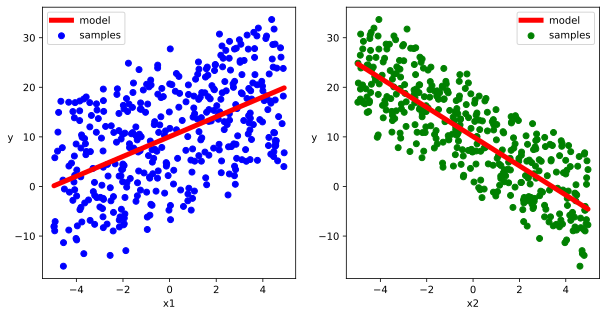

In [211]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
w,b = model.state_dict()["weight"],model.state_dict()["bias"]

plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0,0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

### MLP classification example

In [214]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

#### data

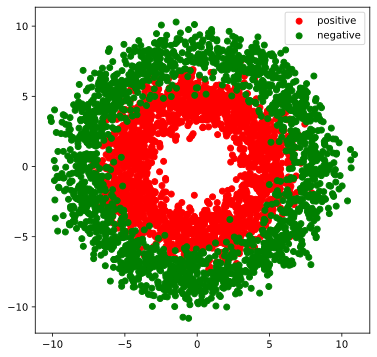

In [212]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#正负样本数量
n_positive,n_negative = 2000,2000
#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1])
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p) 
#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1])
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n) 
#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0) 
#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

#### dataloader

In [213]:
#构建输入数据管道
ds = TensorDataset(X,Y)
dl = DataLoader(ds,batch_size = 10,shuffle=True,num_workers=2)

#### model

In [216]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8)
        self.fc3 = nn.Linear(8,1)
    # 正向传播
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y
    # 损失函数
    def loss_func(self,y_pred,y_true):
        return nn.BCELoss()(y_pred,y_true)
    # 评估函数(准确率)
    def metric_func(self,y_pred,y_true):
        y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                             torch.zeros_like(y_pred,dtype = torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
    # 优化器
    @property
    def optimizer(self):
        return torch.optim.Adam(self.parameters(),lr = 0.001)
model = DNNModel()

In [217]:
# 测试模型结构
(features,labels) = next(iter(dl))
predictions = model(features)

loss = model.loss_func(predictions,labels)
metric = model.metric_func(predictions,labels)

print("init loss:",loss.item())
print("init metric:",metric.item())

init loss: 0.7262361645698547
init metric: 0.5


#### train

In [218]:
def train_step(model, features, labels):
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
    
    # 反向传播求梯度
    loss.backward()
    
    # 更新模型参数
    model.optimizer.step()
    model.optimizer.zero_grad()
    
    return loss.item(),metric.item()
# 测试train_step效果
features,labels = next(iter(dl))
train_step(model,features,labels)

(0.7763653993606567, 0.30000001192092896)

In [220]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in dl:
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)
        if epoch%10==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)
train_model(model,epochs = 50)


================================================================================2021-08-08 14:43:38
epoch = 10 loss =  0.2185864655970363 metric =  0.9172499932348728

================================================================================2021-08-08 14:44:14
epoch = 20 loss =  0.22436013338479824 metric =  0.9214999921619892

================================================================================2021-08-08 14:44:52
epoch = 30 loss =  0.2278347504987323 metric =  0.9232499922811985

================================================================================2021-08-08 14:45:27
epoch = 40 loss =  0.23423828767345184 metric =  0.9204999925196171

================================================================================2021-08-08 14:46:00
epoch = 50 loss =  0.23470123902447085 metric =  0.9262499922513961


#### evaluate

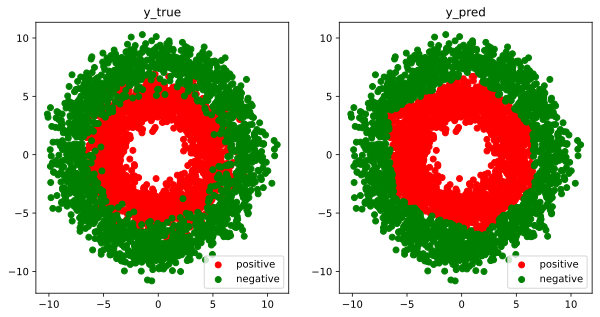

In [222]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (10,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

### Dataset & DataLoader

    Pytorch通常使用Dataset和DataLoader这两个工具类来构建数据管道。
    Dataset定义了数据集的内容，它相当于一个类似列表的数据结构，具有确定的长度，能够用索引获取数据集中的元素。
    而DataLoader定义了按batch加载数据集的方法，它是一个实现了 __iter__ 方法的可迭代对象，每次迭代输出一个batch的数据。
    DataLoader能够控制batch的大小，batch中元素的采样方法，以及将batch结果整理成模型所需输入形式的方法，并且能够使用多进程读取数据。
    在绝大部分情况下，用户只需实现Dataset的 __len__ 方法和 __getitem__ 方法，就可以轻松构建自己的数据集，并用默认数据管道进行加载。

#### Dataset和DataLoader概述

让我们考虑一下从一个数据集中获取一个batch的数据需要哪些步骤。
(假定数据集的特征和标签分别表示为张量 X 和 Y ，数据集可以表示为 (X,Y) , 假定batch大小为
m ) 

    1，首先我们要确定数据集的长度 n 。结果类似： n = 1000 。 
    2，然后我们从 0 到 n-1 的范围中抽样出 m 个数(batch大小)。假定 m=4 , 拿到的结果是一个列表，类似： indices = [1,4,8,9]
    3，接着我们从数据集中去取这 m 个数对应下标的元素。拿到的结果是一个元组列表，类似： samples = [(X[1],Y[1]),(X[4],Y[4]),(X[8],Y[8]),(X[9],Y[9])]
    4，最后我们将结果整理成两个张量作为输出。拿到的结果是两个张量，类似 batch = (features,labels) ，其中 features = torch.stack([X[1],X[4],X[8],X[9]]) labels = torch.stack([Y[1],Y[4],Y[8],Y[9]])

    上述第1个步骤确定数据集的长度是由 Dataset的 __len__ 方法实现的。
    第2个步骤从 0 到 n-1 的范围中抽样出 m 个数的方法是由 DataLoader的 sampler 和  batch_sampler 参数指定的。
    sampler 参数指定单个元素抽样方法，一般无需用户设置，程序默认在DataLoader的参数 shuffle=True 时采用随机抽样， shuffle=False 时采用顺序抽样。
    batch_sampler 参数将多个抽样的元素整理成一个列表，一般无需用户设置，默认方法在DataLoader的参数 drop_last=True 时会丢弃数据集最后一个长度不能被batch大小整除的批次，在 drop_last=False 时保留最后一个批次。
    第3个步骤的核心逻辑根据下标取数据集中的元素 是由 Dataset的 __getitem__ 方法实现的。
    第4个步骤的逻辑由DataLoader的参数 collate_fn 指定。一般情况下也无需用户设置。

In [ ]:
# Dataset和DataLoader的主要接口
# 以下是 Dataset和 DataLoader的核心接口逻辑伪代码，不完全和源码一致。
import torch
class Dataset(object):
    def __init__(self):
        pass
    def __len__(self):
        raise NotImplementedError
    def __getitem__(self,index):
        raise NotImplementedError
class DataLoader(object):
    def __init__(self,dataset,batch_size,collate_fn,shuffle = True,drop_last = False):
        self.dataset = dataset
        self.sampler =torch.utils.data.RandomSampler if shuffle else torch.utils.data.SequentialSampler
        self.batch_sampler = torch.utils.data.BatchSampler
        self.sample_iter = self.batch_sampler(
        self.sampler(range(len(dataset))),
        batch_size = batch_size,drop_last = drop_last)
    def __next__(self):
        indices = next(self.sample_iter)
        batch = self.collate_fn([self.dataset[i] for i in indices])
        return batch

#### 使用Dataset创建数据集

Dataset创建数据集常用的方法有：
    
    • 使用 torch.utils.data.TensorDataset 根据Tensor创建数据集(numpy的array，Pandas的DataFrame需要先转换成Tensor)。
    • 使用 torchvision.datasets.ImageFolder 根据图片目录创建图片数据集。
    • 继承 torch.utils.data.Dataset 创建自定义数据集。
此外，还可以通过
    
    • torch.utils.data.random_split 将一个数据集分割成多份，常用于分割训练集，验证集和测试集。
    • 调用Dataset的加法运算符( + )将多个数据集合并成一个数据集。

##### 根据Tensor创建数据集

In [348]:
import numpy as np
import torch
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split

In [ ]:
# 根据Tensor创建数据集
from sklearn import datasets
iris = datasets.load_iris()
ds_iris = TensorDataset(torch.tensor(iris.data),torch.tensor(iris.target))

# 分割成训练集和预测集
n_train = int(len(ds_iris)*0.8)
n_valid = len(ds_iris) - n_train
ds_train,ds_valid = random_split(ds_iris,[n_train,n_valid])

print(type(ds_iris))
print(type(ds_train))

In [ ]:
# 使用DataLoader加载数据集
dl_train,dl_valid = DataLoader(ds_train,batch_size = 8),DataLoader(ds_valid,batch_size = 8)
for features,labels in dl_train:
    print(features,labels)
    break

In [ ]:
# 演示加法运算符（`+`）的合并作用
ds_data = ds_train + ds_valid

print('len(ds_train) = ',len(ds_train))
print('len(ds_valid) = ',len(ds_valid))
print('len(ds_train+ds_valid) = ',len(ds_data))

print(type(ds_data))

##### 根据图片目录创建图片数据集

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms,datasets

In [ ]:
#演示一些常用的图片增强操作
from PIL import Image
img = Image.open('./data/cat.jpeg')
img

In [ ]:
# 随机数值翻转
transforms.RandomVerticalFlip()(img)

In [ ]:
#随机旋转
transforms.RandomRotation(45)(img)

In [ ]:
# 定义图片增强操作
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), #随机水平翻转
    transforms.RandomVerticalFlip(), #随机垂直翻转
    transforms.RandomRotation(45), #随机在45度角度内旋转
    transforms.ToTensor() #转换成张量
 ] )
transform_valid = transforms.Compose([
    transforms.ToTensor()
 ] )

In [ ]:
# 根据图片目录创建数据集
ds_train = datasets.ImageFolder("./data/cifar2/train/", 
                                transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./data/cifar2/test/",
                                transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
print(ds_train.class_to_idx)

In [ ]:
# 使用DataLoader加载数据集
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=3)
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=3)

In [ ]:
for features,labels in dl_train:
    print(features.shape)
    print(labels.shape)
    break

##### 通过集成Dataset类创建自定义文本数据集

    下面通过继承Dataset类创建imdb文本分类任务的自定义数据集。
    大概思路如下：首先，对训练集文本分词构建词典。然后将训练集文本和测试集文本数据转换成token单词编码。
    接着将转换成单词编码的训练集数据和测试集数据按样本分割成多个文件，一个文件代表一个样本。
    最后，我们可以根据文件名列表获取对应序号的样本内容，从而构建Dataset数据集。

In [349]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import re,string
MAX_WORDS = 10000 # 仅考虑最高频的10000个词
MAX_LEN = 200 # 每个样本保留200个词的长度
BATCH_SIZE = 20
train_data_path = 'D:/kwCodes/REcodes/re_datasets/chn_senti_corp_情感分析/train.tsv'
test_data_path = 'D:/kwCodes/REcodes/re_datasets/chn_senti_corp_情感分析/test.tsv'
train_token_path = 'D:/kwCodes/REcodes/re_datasets/chn_senti_corp_情感分析/train_token.tsv'
test_token_path = 'D:/kwCodes/REcodes/re_datasets/chn_senti_corp_情感分析/test_token.tsv'
train_samples_path = 'D:/kwCodes/REcodes/re_datasets/chn_senti_corp_情感分析/train_samples/'
test_samples_path = 'D:/kwCodes/REcodes/re_datasets/chn_senti_corp_情感分析/test_samples/'

首先我们构建词典，并保留最高频的MAX_WORDS个词。

In [350]:
##构建词典
word_count_dict = {}
#清洗文本
def clean_text(text):
    lowercase = text.lower().replace("\n"," ")
    stripped_html = re.sub('<br />', ' ',lowercase)
    cleaned_punctuation = re.sub('[%s]'%re.escape(string.punctuation),'',stripped_html)
    return cleaned_punctuation

with open(train_data_path,"r",encoding = 'utf-8') as f:
    for line in f:
        label,text = line.split("\t")
        cleaned_text = clean_text(text)
        for word in cleaned_text.split(" "):
            word_count_dict[word] = word_count_dict.get(word,0)+1

df_word_dict = pd.DataFrame(pd.Series(word_count_dict,name = "count"))
df_word_dict = df_word_dict.sort_values(by = "count",ascending =False)

df_word_dict = df_word_dict[0:MAX_WORDS-2] # 
df_word_dict["word_id"] = range(2,MAX_WORDS) #编号0和1分别留给未知词<unkown>和填充<padding>

word_id_dict = df_word_dict["word_id"].to_dict()
df_word_dict.head(10)

count  word_id
       9673        2
：       356        3
补充点评    195        4
宾馆反馈    157        5
2        60        6
1        57        7
3        52        8
4        36        9
the      35       10
5        22       11

然后我们利用构建好的词典，将文本转换成token序号。

In [351]:
#转换token
# 填充文本
def pad(data_list,pad_length):
    padded_list = data_list.copy()
    if len(data_list)> pad_length:
        padded_list = data_list[-pad_length:]
    if len(data_list)< pad_length:
        padded_list = [1]*(pad_length-len(data_list))+data_list
    return padded_list

def text_to_token(text_file,token_file):
    with open(text_file,"r",encoding = 'utf-8') as fin,\
        open(token_file,"w",encoding = 'utf-8') as fout:
            for line in fin:
                label,text = line.split("\t")
                cleaned_text = clean_text(text)
                word_token_list = [word_id_dict.get(word, 0) for word in cleaned_text.split(" ")]
                pad_list = pad(word_token_list,MAX_LEN)
                out_line = label+"\t"+" ".join([str(x) for x in pad_list])
                fout.write(out_line+"\n")

text_to_token(train_data_path,train_token_path)
text_to_token(test_data_path,test_token_path)

接着将token文本按照样本分割，每个文件存放一个样本的数据

In [352]:
# 分割样本
import os
if not os.path.exists(train_samples_path):
    os.mkdir(train_samples_path)
if not os.path.exists(test_samples_path):
    os.mkdir(test_samples_path)
def split_samples(token_path,samples_dir):
    with open(token_path,"r",encoding = 'utf-8') as fin:
        i = 0
        for line in fin:
            with open(samples_dir+"%d.txt"%i,"w",encoding = "utf-8") as fout:
                fout.write(line)
            i = i+1

split_samples(train_token_path,train_samples_path)
split_samples(test_token_path,test_samples_path)

In [353]:
print(os.listdir(train_samples_path)[0:100])

['0.txt', '1.txt', '10.txt', '100.txt', '1000.txt', '1001.txt', '1002.txt', '1003.txt', '1004.txt', '1005.txt', '1006.txt', '1007.txt', '1008.txt', '1009.txt', '101.txt', '1010.txt', '1011.txt', '1012.txt', '1013.txt', '1014.txt', '1015.txt', '1016.txt', '1017.txt', '1018.txt', '1019.txt', '102.txt', '1020.txt', '1021.txt', '1022.txt', '1023.txt', '1024.txt', '1025.txt', '1026.txt', '1027.txt', '1028.txt', '1029.txt', '103.txt', '1030.txt', '1031.txt', '1032.txt', '1033.txt', '1034.txt', '1035.txt', '1036.txt', '1037.txt', '1038.txt', '1039.txt', '104.txt', '1040.txt', '1041.txt', '1042.txt', '1043.txt', '1044.txt', '1045.txt', '1046.txt', '1047.txt', '1048.txt', '1049.txt', '105.txt', '1050.txt', '1051.txt', '1052.txt', '1053.txt', '1054.txt', '1055.txt', '1056.txt', '1057.txt', '1058.txt', '1059.txt', '106.txt', '1060.txt', '1061.txt', '1062.txt', '1063.txt', '1064.txt', '1065.txt', '1066.txt', '1067.txt', '1068.txt', '1069.txt', '107.txt', '1070.txt', '1071.txt', '1072.txt', '1073.t

一切准备就绪，我们可以创建数据集Dataset, 从文件名称列表中读取文件内容了

In [355]:
import os
class imdbDataset(Dataset):
    def __init__(self,samples_dir):
        self.samples_dir = samples_dir
        self.samples_paths = os.listdir(samples_dir)
    def __len__(self):
        return len(self.samples_paths)
    def __getitem__(self,index):
        path = self.samples_dir + self.samples_paths[index]
        with open(path,"r",encoding = "utf-8") as f:
            line = f.readline()
            label,tokens = line.split("\t")
            label = torch.tensor([float(label)],dtype = torch.float)
            feature = torch.tensor([int(x) for x in tokens.split(" ")],dtype = torch.long)
            return (feature,label)
ds_train = imdbDataset(train_samples_path)
ds_test = imdbDataset(test_samples_path)

In [356]:
print(len(ds_train))
print(len(ds_test))

9601
1201


In [364]:
dl_train = DataLoader(ds_train,batch_size = BATCH_SIZE,shuffle =True)
dl_test = DataLoader(ds_test,batch_size = BATCH_SIZE)
for features,labels in dl_train:
    print(features)
    print(labels)
    print(type(features))
    print(type(labels))
    break

tensor([[   1,    1,    1,  ...,    3, 1293,    2],
        [   1,    1,    1,  ...,    1,  702,    2],
        [   1,    1,    1,  ...,    1, 7841,    2],
        ...,
        [   1,    1,    1,  ...,    1,  742,    2],
        [   1,    1,    1,  ..., 8076, 8077,    2],
        [   1,    1,    1,  ...,    0,    0,    2]])
tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.]])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


最后构建模型测试一下数据集管道是否可用。

In [361]:
import torch
from torch import nn
import importlib
from torchkeras import Model,summary
class Net(Model):
    def __init__(self):
        super(Net, self).__init__()
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量
        self.embedding = nn.Embedding(num_embeddings = MAX_WORDS,embedding_dim = 3,padding_idx = 1)
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1",nn.Conv1d(in_channels = 3,out_channels = 16,kernel_size = 5))
        self.conv.add_module("pool_1",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1",nn.ReLU())
        self.conv.add_module("conv_2",nn.Conv1d(in_channels = 16,out_channels = 128,kernel_size = 2))
        self.conv.add_module("pool_2",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_2",nn.ReLU())
        self.dense = nn.Sequential()
        self.dense.add_module("flatten",nn.Flatten())
        self.dense.add_module("linear",nn.Linear(6144,1))
        self.dense.add_module("sigmoid",nn.Sigmoid())

    def forward(self,x):
        x = self.embedding(x).transpose(1,2)
        x = self.conv(x)
        y = self.dense(x)
        return y

model = Net()
print(model)
model.summary(input_shape = (200,),input_dtype = torch.LongTensor)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5      

In [362]:
# 编译模型
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32), 
                         torch.zeros_like(y_pred,dtype = torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc
model.compile(loss_func = nn.BCELoss(),optimizer= torch.optim.Adagrad(model.parameters(),lr = 0.02), 
              metrics_dict={"accuracy":accuracy})

In [ ]:
# 训练模型
dfhistory = model.fit(3,dl_train,dl_val=dl_test,log_step_freq= 20)

#### 使用DataLoader加载数据集

DataLoader能够控制batch的大小，batch中元素的采样方法，以及将batch结果整理成模型所需
输入形式的方法，并且能够使用多进程读取数据。

DataLoader的函数签名如下。

    DataLoader(
     dataset,
     batch_size=1,
     shuffle=False,
     sampler=None,
     batch_sampler=None,
     num_workers=0,
     collate_fn=None,
     pin_memory=False,
     drop_last=False,
     timeout=0,
     worker_init_fn=None,
     multiprocessing_context=None, )
一般情况下，我们仅仅会配置 dataset, batch_size, shuffle, num_workers, drop_last这五个参数，其他参数使用默认值即可。

DataLoader除了可以加载我们前面讲的 torch.utils.data.Dataset 外，还能够加载另外一种数据集torch.utils.data.IterableDataset。 

和Dataset数据集相当于一种列表结构不同，IterableDataset相当于一种迭代器结构。 它更加复
杂，一般较少使用。

    • dataset : 数据集
    • batch_size: 批次大小
    • shuffle: 是否乱序
    • sampler: 样本采样函数，一般无需设置。
    • batch_sampler: 批次采样函数，一般无需设置。
    • num_workers: 使用多进程读取数据，设置的进程数。
    • collate_fn: 整理一个批次数据的函数。
    • pin_memory: 是否设置为锁业内存。默认为False，锁业内存不会使用虚拟内存(硬盘)，从锁
    业内存拷贝到GPU上速度会更快。
    • drop_last: 是否丢弃最后一个样本数量不足batch_size批次数据。
    • timeout: 加载一个数据批次的最长等待时间，一般无需设置。
    • worker_init_fn: 每个worker中dataset的初始化函数，常用于 IterableDataset。一般不使用。

In [366]:
#构建输入数据管道
ds = TensorDataset(torch.arange(1,50))
dl = DataLoader(ds,
                batch_size = 10,
                shuffle= True,
                num_workers=2,
                drop_last = True) 
#迭代数据
for batch, in dl:
    print(batch)

tensor([34,  5, 46, 32,  9, 36, 25, 20, 21, 10])
tensor([ 8, 40, 19, 42,  1, 15, 38, 47, 23, 11])
tensor([ 7, 37, 33, 27, 29, 31,  2, 41, 18, 43])
tensor([17, 12, 48, 28, 39,  3, 22,  6, 24, 44])


### 模型层layers

深度学习模型一般由各种模型层组合而成。

torch.nn中内置了非常丰富的各种模型层。它们都属于nn.Module的子类，具备参数管理功能。

例如：

    • nn.Linear, nn.Flatten, nn.Dropout, nn.BatchNorm2d
    • nn.Conv2d,nn.AvgPool2d,nn.Conv1d,nn.ConvTranspose2d
    • nn.Embedding,nn.GRU,nn.LSTM
    • nn.Transformer
如果这些内置模型层不能够满足需求，我们也可以通过继承nn.Module基类构建自定义的模型层。

实际上，pytorch不区分模型和模型层，都是通过继承nn.Module进行构建。

因此，我们只要继承nn.Module基类并实现forward方法即可自定义模型层

#### 内置模型层

In [367]:
import numpy as np
import torch
from torch import nn

一些常用的内置模型层简单介绍如下。

    基础层
    • nn.Linear：全连接层。参数个数 = 输入层特征数× 输出层特征数(weight)＋ 输出层特征数(bias)
    • nn.Flatten：压平层，用于将多维张量样本压成一维张量样本。
    • nn.BatchNorm1d：一维批标准化层。通过线性变换将输入批次缩放平移到稳定的均值和标准差。可以增强模型对输入不同分布的适应性，加快模型训练速度，有轻微正则化效果。一般在激活函数之前使用。可以用afine参数设置该层是否含有可以训练的参数。
    • nn.BatchNorm2d：二维批标准化层。
    • nn.BatchNorm3d：三维批标准化层。
    • nn.Dropout：一维随机丢弃层。一种正则化手段。
    • nn.Dropout2d：二维随机丢弃层。
    • nn.Dropout3d：三维随机丢弃层。
    • nn.Threshold：限幅层。当输入大于或小于阈值范围时，截断之。
    • nn.ConstantPad2d： 二维常数填充层。对二维张量样本填充常数扩展长度。
    • nn.ReplicationPad1d： 一维复制填充层。对一维张量样本通过复制边缘值填充扩展长度。
    • nn.ZeroPad2d：二维零值填充层。对二维张量样本在边缘填充0值.
    • nn.GroupNorm：组归一化。一种替代批归一化的方法，将通道分成若干组进行归一。不受batch大小限制，据称性能和效果都优于BatchNorm。
    • nn.LayerNorm：层归一化。较少使用。
    • nn.InstanceNorm2d: 样本归一化。较少使用。
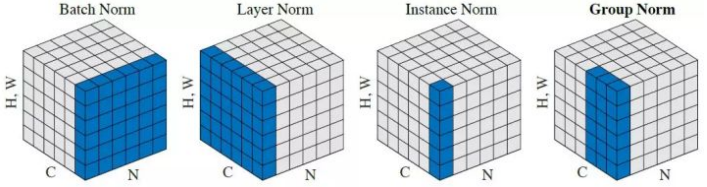

    卷积网络相关层
    • nn.Conv1d：普通一维卷积，常用于文本。参数个数 = 输入通道数×卷积核尺寸(如3)×卷积核个数 + 卷积核尺寸(如3）
    • nn.Conv2d：普通二维卷积，常用于图像。参数个数 = 输入通道数×卷积核尺寸(如3乘3)×卷积核个数 + 卷积核尺寸(如3乘3) 通过调整dilation参数大于1，可以变成空洞卷积，增大卷积核感受野。 通过调整groups参数不为1，可以变成分组卷积。分组卷积中不同分组使用相同的卷积核，显著减少参数数量。 当groups参数等于通道数时，相当于tensorflow中的二维深度卷积层tf.keras.layers.DepthwiseConv2D。 利用分组卷积和1乘1卷积的组合操作，可以构造相当于Keras中的二维深度可分离卷积层tf.keras.layers.SeparableConv2D。
    • nn.Conv3d：普通三维卷积，常用于视频。参数个数 = 输入通道数×卷积核尺寸(如3乘3乘3)×卷积核个数 + 卷积核尺寸(如3乘3乘3) 。
    • nn.MaxPool1d: 一维最大池化。
    • nn.MaxPool2d：二维最大池化。一种下采样方式。没有需要训练的参数。
    • nn.MaxPool3d：三维最大池化。
    • nn.AdaptiveMaxPool2d：二维自适应最大池化。无论输入图像的尺寸如何变化，输出的图像尺寸是固定的。 该函数的实现原理，大概是通过输入图像的尺寸和要得到的输出图像的尺寸来反向推算池化算子的padding,stride等参数。
    • nn.FractionalMaxPool2d：二维分数最大池化。普通最大池化通常输入尺寸是输出的整数倍。而分数最大池化则可以不必是整数。分数最大池化使用了一些随机采样策略，有一定的正则效果，可以用它来代替普通最大池化和Dropout层。
    • nn.AvgPool2d：二维平均池化。
    • nn.AdaptiveAvgPool2d：二维自适应平均池化。无论输入的维度如何变化，输出的维度是固定的。
    • nn.ConvTranspose2d：二维卷积转置层，俗称反卷积层。并非卷积的逆操作，但在卷积核相同的情况下，当其输入尺寸是卷积操作输出尺寸的情况下，卷积转置的输出尺寸恰好是卷积操作的输入尺寸。在语义分割中可用于上采样。
    • nn.Upsample：上采样层，操作效果和池化相反。可以通过mode参数控制上采样策略为”nearest”最邻近策略或”linear”线性插值策略。
    • nn.Unfold：滑动窗口提取层。其参数和卷积操作nn.Conv2d相同。实际上，卷积操作可以等价于nn.Unfold和nn.Linear以及nn.Fold的一个组合。 其中nn.Unfold操作可以从输入中提取各个滑动窗口的数值矩阵，并将其压平成一维。利用nn.Linear将nn.Unfold的输出和卷积核做乘法后，再使用 nn.Fold操作将结果转换成输出图片形状。
    • nn.Fold：逆滑动窗口提取层。

    循环网络相关层
    • nn.Embedding：嵌入层。一种比Onehot更加有效的对离散特征进行编码的方法。一般用于将输入中的单词映射为稠密向量。嵌入层的参数需要学习。
    • nn.LSTM：长短记忆循环网络层【支持多层】。最普遍使用的循环网络层。具有携带轨道，遗忘门，更新门，输出门。可以较为有效地缓解梯度消失问题，从而能够适用长期依赖问题。设置bidirectional = True时可以得到双向LSTM。需要注意的时，默认的输入和输出形状是(seq,batch,feature), 如果需要将batch维度放在第0维，则要设置batch_first参数设置为True。
    • nn.GRU：门控循环网络层【支持多层】。LSTM的低配版，不具有携带轨道，参数数量少于LSTM，训练速度更快。
    • nn.RNN：简单循环网络层【支持多层】。容易存在梯度消失，不能够适用长期依赖问题。一般较少使用。
    • nn.LSTMCell：长短记忆循环网络单元。和nn.LSTM在整个序列上迭代相比，它仅在序列上迭代一步。一般较少使用。
    • nn.GRUCell：门控循环网络单元。和nn.GRU在整个序列上迭代相比，它仅在序列上迭代一步。一般较少使用。
    • nn.RNNCell：简单循环网络单元。和nn.RNN在整个序列上迭代相比，它仅在序列上迭代一步。一般较少使用。

    Transformer相关层
    • nn.Transformer：Transformer网络结构。Transformer网络结构是替代循环网络的一种结构，解决了循环网络难以并行，难以捕捉长期依赖的缺陷。它是目前NLP任务的主流模型的主要构成部分。Transformer网络结构由TransformerEncoder编码器和TransformerDecoder解码器组成。编码器和解码器的核心是MultiheadAttention多头注意力层。
    • nn.TransformerEncoder：Transformer编码器结构。由多个 nn.TransformerEncoderLayer编码器层组成。
    • nn.TransformerDecoder：Transformer解码器结构。由多个 nn.TransformerDecoderLayer解码器层组成。
    • nn.TransformerEncoderLayer：Transformer的编码器层。
    • nn.TransformerDecoderLayer：Transformer的解码器层。
    • nn.MultiheadAttention：多头注意力层。

#### 自定义模型层

如果Pytorch的内置模型层不能够满足需求，我们也可以通过继承nn.Module基类构建自定义的模型层。

实际上，pytorch不区分模型和模型层，都是通过继承nn.Module进行构建。

因此，我们只要继承nn.Module基类并实现forward方法即可自定义模型层。

下面是Pytorch的nn.Linear层的源码，我们可以仿照它来自定义模型层。

In [368]:
import torch
from torch import nn
import torch.nn.functional as F
class Linear(nn.Module):
    __constants__ = ['in_features', 'out_features']
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        def forward(self, input):
            return F.linear(input, self.weight, self.bias)
        def extra_repr(self):
            return 'in_features={}, out_features={}, bias={}'.format(
                self.in_features, self.out_features, self.bias is not None
            )

In [369]:
linear = nn.Linear(20, 30)
inputs = torch.randn(128, 20)
output = linear(inputs)
print(output.size())

torch.Size([128, 30])


### 损失函数loss

一般来说，监督学习的目标函数由损失函数和正则化项组成。(Objective = Loss + Regularization)

Pytorch中的损失函数一般在训练模型时候指定。

注意Pytorch中内置的损失函数的参数和tensorflow不同，是y_pred在前，y_true在后，而Tensorflow是y_true在前，y_pred在后。

对于回归模型，通常使用的内置损失函数是均方损失函数nn.MSELoss 。

对于二分类模型，通常使用的是二元交叉熵损失函数nn.BCELoss (输入已经是sigmoid激活函数之后的结果) 或者 nn.BCEWithLogitsLoss (输入尚未经过nn.Sigmoid激活函数) 。

对于多分类模型，一般推荐使用交叉熵损失函数 nn.CrossEntropyLoss。 (y_true需要是一维的，是类别编码。y_pred未经过nn.Softmax激活。) 

此外，如果多分类的y_pred经过了nn.LogSoftmax激活，可以使用nn.NLLLoss损失函数(The negative log likelihood loss)。 这种方法和直接使用nn.CrossEntropyLoss等价。

如果有需要，也可以自定义损失函数，自定义损失函数需要接收两个张量y_pred，y_true作为输入参数，并输出一个标量作为损失函数值。

Pytorch中的正则化项一般通过自定义的方式和损失函数一起添加作为目标函数。

如果仅仅使用L2正则化，也可以利用优化器的weight_decay参数来实现相同的效果。

#### 内置损失函数

In [370]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F

y_pred = torch.tensor([[10.0,0.0,-10.0],[8.0,8.0,8.0]])
y_true = torch.tensor([0,2])

# 直接调用交叉熵损失
ce = nn.CrossEntropyLoss()(y_pred,y_true)
print(ce)

# 等价于先计算nn.LogSoftmax激活，再调用NLLLoss
y_pred_logsoftmax = nn.LogSoftmax(dim = 1)(y_pred)
nll = nn.NLLLoss()(y_pred_logsoftmax,y_true)
print(nll)

tensor(0.5493)
tensor(0.5493)


内置的损失函数一般有类的实现和函数的实现两种形式。

如：nn.BCE 和 F.binary_cross_entropy 都是二元交叉熵损失函数，前者是类的实现形式，后者是函数的实现形式。

实际上类的实现形式通常是调用函数的实现形式并用nn.Module封装后得到的。

一般我们常用的是类的实现形式。它们封装在torch.nn模块下，并且类名以Loss结尾。

常用的一些内置损失函数说明如下。

    • nn.MSELoss（均方误差损失，也叫做L2损失，用于回归）
    • nn.L1Loss （L1损失，也叫做绝对值误差损失，用于回归）
    • nn.SmoothL1Loss (平滑L1损失，当输入在-1到1之间时，平滑为L2损失，用于回归)
    • nn.BCELoss (二元交叉熵，用于二分类，输入已经过nn.Sigmoid激活，对不平衡数据集可以用weigths参数调整类别权重)
    • nn.BCEWithLogitsLoss (二元交叉熵，用于二分类，输入未经过nn.Sigmoid激活)
    • nn.CrossEntropyLoss (交叉熵，用于多分类，要求label为稀疏编码，输入未经过nn.Softmax激活，对不平衡数据集可以用weigths参数调整类别权重)
    • nn.NLLLoss (负对数似然损失，用于多分类，要求label为稀疏编码，输入经过nn.LogSoftmax激活)
    • nn.CosineSimilarity(余弦相似度，可用于多分类)
    • nn.AdaptiveLogSoftmaxWithLoss (一种适合非常多类别且类别分布很不均衡的损失函数，会自适应地将多个小类别合成一个cluster)

#### 自定义损失函数

自定义损失函数接收两个张量y_pred,y_true作为输入参数，并输出一个标量作为损失函数值。

也可以对nn.Module进行子类化，重写forward方法实现损失的计算逻辑，从而得到损失函数的类的实现。

下面是一个Focal Loss的自定义实现示范。Focal Loss是一种对binary_crossentropy的改进损失函数形式。

它在样本不均衡和存在较多易分类的样本时相比binary_crossentropy具有明显的优势。

它有两个可调参数，alpha参数和gamma参数。其中alpha参数主要用于衰减负样本的权重，gamma参数主要用于衰减容易训练样本的权重。

从而让模型更加聚焦在正样本和困难样本上。这就是为什么这个损失函数叫做Focal Loss。

In [6]:
class FocalLoss(nn.Module):
    def __init__(self,gamma=2.0,alpha=0.75):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
    def forward(self,y_pred,y_true):
        bce = torch.nn.BCELoss(reduction = "none")(y_pred,y_true)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = torch.pow(1.0 - p_t, self.gamma)
        loss = torch.mean(alpha_factor * modulating_factor * bce)
        return loss

#困难样本
y_pred_hard = torch.tensor([[0.5],[0.5]])
y_true_hard = torch.tensor([[1.0],[0.0]])

#容易样本
y_pred_easy = torch.tensor([[0.9],[0.1]])
y_true_easy = torch.tensor([[1.0],[0.0]])

focal_loss = FocalLoss()
bce_loss = nn.BCELoss()

print("focal_loss(hard samples):", focal_loss(y_pred_hard,y_true_hard))
print("bce_loss(hard samples):", bce_loss(y_pred_hard,y_true_hard))
print("focal_loss(easy samples):", focal_loss(y_pred_easy,y_true_easy))
print("bce_loss(easy samples):", bce_loss(y_pred_easy,y_true_easy))

#可见 focal_loss让容易样本的权重衰减到原来的 0.0005/0.1054 = 0.00474
#而让困难样本的权重只衰减到原来的 0.0866/0.6931=0.12496
# 因此相对而言，focal_loss可以衰减容易样本的权重。

focal_loss(hard samples): tensor(0.0866)
bce_loss(hard samples): tensor(0.6931)
focal_loss(easy samples): tensor(0.0005)
bce_loss(easy samples): tensor(0.1054)


FocalLoss的使用完整范例可以参考下面中 自定义L1和L2正则化项 中的范例，该范例既演示了自定
义正则化项的方法，也演示了FocalLoss的使用方法。

#### 自定义L1和L2正则化项 - 利用正则化与Focal Loss较好的解决数据不平衡问题

通常认为L1 正则化可以产生稀疏权值矩阵，即产生一个稀疏模型，可以用于特征选择。

而L2 正则化可以防止模型过拟合（overfitting）。一定程度上，L1也可以防止过拟合。

下面以一个二分类问题为例，演示给模型的目标函数添加自定义L1和L2正则化项的方法。

这个范例同时演示了上一个部分的FocalLoss的使用。

##### data

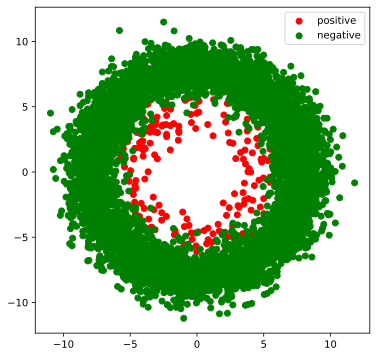

In [1]:
# data
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchkeras
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 200,6000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1])
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1])
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n) 

#汇总样本
X = torch.cat([Xp,Xn],axis = 0) 
Y = torch.cat([Yp,Yn],axis = 0) 

#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);

##### iter

In [4]:
# iter
ds = TensorDataset(X,Y)
ds_train,ds_valid = torch.utils.data.random_split(ds, [int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 100,shuffle=True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 100,num_workers=2)

##### model

In [2]:
# model
class DNNModel(torchkeras.Model):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8)
        self.fc3 = nn.Linear(8,1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y
model = DNNModel()
model.summary(input_shape =(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------


In [10]:
#  train
# 准确率
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
    torch.zeros_like(y_pred,dtype = torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc
# L2正则化
def L2Loss(model,alpha):
    l2_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name: #一般不对偏置项使用正则
            l2_loss = l2_loss + (0.5 * alpha * torch.sum(torch.pow(param, 2)))
    return l2_loss
# L1正则化
def L1Loss(model,beta):
    l1_loss = torch.tensor(0.0, requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            l1_loss = l1_loss + beta * torch.sum(torch.abs(param))
    return l1_loss
# 将L2正则和L1正则添加到FocalLoss损失，一起作为目标函数
def focal_loss_with_regularization(y_pred,y_true):
    focal = FocalLoss()(y_pred,y_true)
    l2_loss = L2Loss(model,0.001) #注意设置正则化项系数
    l1_loss = L1Loss(model,0.001)
    total_loss = focal + l2_loss + l1_loss
    return total_loss

model.compile(loss_func =focal_loss_with_regularization,
              optimizer= torch.optim.Adam(model.parameters(),lr = 0.01),
              metrics_dict={"accuracy":accuracy})
dfhistory = model.fit(3,dl_train = dl_train,dl_val = dl_valid,log_step_freq = 30)

Start Training ...

================================================================================2021-08-08 23:07:18
{'step': 30, 'loss': 0.016, 'accuracy': 0.986}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.016 |  0.985   |  0.017   |    0.976     |
+-------+-------+----------+----------+--------------+

================================================================================2021-08-08 23:07:22
{'step': 30, 'loss': 0.016, 'accuracy': 0.982}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   2   | 0.016 |  0.983   |  0.017   |    0.981     |
+-------+-------+----------+----------+--------------+

================================================================================2021-08-08 23:07:26
{'step': 30, 'loss': 0.016, 'a

##### evaluate

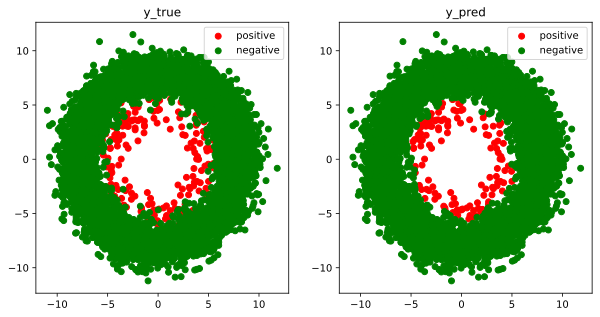

In [11]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (10,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

#### 通过优化器实现L2正则化

如果仅仅需要使用L2正则化，那么也可以利用优化器的weight_decay参数来实现。

weight_decay参数可以设置参数在训练过程中的衰减，这和L2正则化的作用效果等价。

    before L2 regularization:
    gradient descent: w = w - lr * dloss_dw 
    after L2 regularization:
    gradient descent: w = w - lr * (dloss_dw+beta*w) = (1-lr*beta)*w - lr*dloss_dw
    so （1-lr*beta）is the weight decay ratio.

Pytorch的优化器支持一种称之为Per-parameter options的操作，就是对每一个参数进行特定的学习率，权重衰减率指定，以满足更为细致的要求

In [ ]:
weight_params = [param for name, param in model.named_parameters() if "bias" not in name]
bias_params = [param for name, param in model.named_parameters() if "bias" in name]
optimizer = torch.optim.SGD([{'params': weight_params, 'weight_decay':1e-5},
                             {'params': bias_params, 'weight_decay':0}],
                              lr=1e-2, momentum=0.9)

### TensorBoard

在我们的炼丹过程中，如果能够使用丰富的图像来展示模型的结构，指标的变化，参数的分布，输入的形态等信息，无疑会提升我们对问题的洞察力，并增加许多炼丹的乐趣。

TensorBoard正是这样一个神奇的炼丹可视化辅助工具。它原是TensorFlow的小弟，但它也能够很好地和Pytorch进行配合。甚至在Pytorch中使用TensorBoard比TensorFlow中使用TensorBoard还要来的更加简单和自然。

Pytorch中利用TensorBoard可视化的大概过程如下：

首先在Pytorch中指定一个目录创建一个torch.utils.tensorboard.SummaryWriter日志写入器。

然后根据需要可视化的信息，利用日志写入器将相应信息日志写入我们指定的目录。

最后就可以传入日志目录作为参数启动TensorBoard，然后就可以在TensorBoard中愉快地看片了。

我们主要介绍Pytorch中利用TensorBoard进行如下方面信息的可视化的方法。

    • 可视化模型结构： writer.add_graph
    • 可视化指标变化： writer.add_scalar
    • 可视化参数分布： writer.add_histogram
    • 可视化原始图像： writer.add_image 或 writer.add_images
    • 可视化人工绘图： writer.add_figure

#### 可视化模型结构

In [12]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchkeras import Model,summary

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [15]:
summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

D:\Anaconda\envs\Deep\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [16]:
writer = SummaryWriter('./tensorboard')
writer.add_graph(net,input_to_model = torch.rand(1,3,32,32))
writer.close()

In [17]:
%load_ext tensorboard
#%tensorboard --logdir ./data/tensorboard

In [18]:
from tensorboard import notebook
#查看启动的tensorboard程序
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./tensorboard (started 1 day, 13:18:11 ago; pid 31832)
  - port 6006: logdir ./data/tensorboard (started 1 day, 13:20:21 ago; pid 3312)


In [19]:
#启动tensorboard程序
notebook.start("--logdir ./tensorboard") #等价于在命令行中执行 tensorboard --logdir ./data/tensorboard
#可以在浏览器中打开 http://localhost:6006/ 查看

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7692.

#### 可视化指标变化

有时候在训练过程中，如果能够实时动态地查看loss和各种metric的变化曲线，那么无疑可以帮助我们更加直观地了解模型的训练情况。

注意，writer.add_scalar仅能对标量的值的变化进行可视化。因此它一般用于对loss和metric的变化进行可视化分析。

In [21]:
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
# f(x) = a*x**2 + b*x + c的最小值
x = torch.tensor(0.0,requires_grad = True) # x需要被求导
a = torch.tensor(1.0)
b = torch.tensor(-2.0)
c = torch.tensor(1.0)
optimizer = torch.optim.SGD(params=[x],lr = 0.01)
def f(x):
    result = a*torch.pow(x,2) + b*x + c
    return(result)
writer = SummaryWriter('./tensorboard')
for i in range(500):
    optimizer.zero_grad()
    y = f(x)
    y.backward()
    optimizer.step()
    writer.add_scalar("x",x.item(),i) #日志中记录x在第step i 的值
    writer.add_scalar("y",y.item(),i) #日志中记录y在第step i 的值
    
writer.close()

print("y=",f(x).data,";","x=",x.data)

y= tensor(0.) ; x= tensor(1.0000)


#### 可视化参数分布

如果需要对模型的参数(一般非标量)在训练过程中的变化进行可视化，可以使用writer.add_histogram。

它能够观测张量值分布的直方图随训练步骤的变化趋势

In [22]:
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

# 创建正态分布的张量模拟参数矩阵
def norm(mean,std):
    t = std*torch.randn((100,20))+mean
    return t

writer = SummaryWriter('./tensorboard')

for step,mean in enumerate(range(-10,10,1)):
    w = norm(mean,1)
    writer.add_histogram("w",w, step)
    writer.flush()
writer.close()

#### 可视化原始图像

如果我们做图像相关的任务，也可以将原始的图片在tensorboard中进行可视化展示。

    如果只写入一张图片信息，可以使用writer.add_image。
    如果要写入多张图片信息，可以使用writer.add_images。
    也可以用 torchvision.utils.make_grid将多张图片拼成一张图片，然后用writer.add_image写入。

注意，传入的是代表图片信息的Pytorch中的张量数据

In [23]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets
transform_train = transforms.Compose(
 [transforms.ToTensor()])
transform_valid = transforms.Compose(
 [transforms.ToTensor()])

In [26]:
ds_train = datasets.ImageFolder("./practice_data/cifar2/train/",
                                transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./practice_data/cifar2/test/",
                                transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
print(ds_train.class_to_idx)

dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True)
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True)

dl_train_iter = iter(dl_train)
images, labels = dl_train_iter.next()

# 仅查看一张图片
writer = SummaryWriter('./tensorboard')
writer.add_image('images[0]', images[0])
writer.close()

# 将多张图片拼接成一张图片，中间用黑色网格分割
writer = SummaryWriter('./tensorboard')
# create grid of images
img_grid = torchvision.utils.make_grid(images)
writer.add_image('image_grid', img_grid)
writer.close()

# 将多张图片直接写入
writer = SummaryWriter('./tensorboard')
writer.add_images("images",images,global_step = 0)
writer.close()

{'airplane': 0, 'automobile': 1}


#### 可视化人工绘图

如果我们将matplotlib绘图的结果再 tensorboard中展示，可以使用 add_figure.

注意，和writer.add_image不同的是，writer.add_figure需要传入matplotlib的figure对象

In [28]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets
transform_train = transforms.Compose(
 [transforms.ToTensor()])
transform_valid = transforms.Compose(
 [transforms.ToTensor()])
ds_train = datasets.ImageFolder("./practice_data/cifar2/train/",
                                transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./practice_data/cifar2/test/",
                                transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
print(ds_train.class_to_idx)

{'airplane': 0, 'automobile': 1}


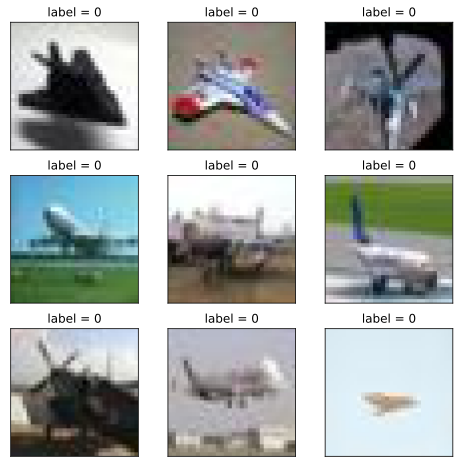

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(8,8))
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [30]:
writer = SummaryWriter('./tensorboard')
writer.add_figure('figure',figure,global_step=0)
writer.close()

## 高阶API - 将torch的train_loop, eval_loop, predict_loop封装成如keras一般，一键开始训练

Pytorch没有官方的高阶API，一般需要用户自己通过nn.Module来构建模型并编写自定义训练循环实现训练循环、验证循环、和预测循环。

为了更加方便地训练模型，作者编写了仿keras的Pytorch模型接口：torchkeras， 作为Pytorch的高阶API,通过仿照tf.keras.Model的功能对Pytorch的nn.Module进行了封装，

实现了 fit, validate，predict, summary 方法，相当于用户自定义高阶API。

本章我们主要详细介绍Pytorch的高阶API如下相关的内容。
    
    • 构建模型的3种方法(继承nn.Module基类，使用nn.Sequential，辅助应用模型容器)
    • 训练模型的3种方法(脚本风格，函数风格，torchkeras.Model类风格)
    • 使用GPU训练模型(单GPU训练，多GPU训练)

### Linear Regression example

In [215]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

#### data

In [225]:
#样本数量
n = 400
# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0 #torch.rand是均匀分布
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1]) # @表示矩阵乘法,增加正态扰动

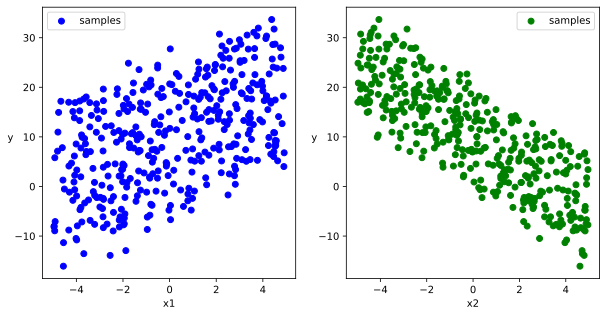

In [202]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

#### dataloader(iter)

In [226]:
#构建输入数据管道
ds = TensorDataset(X,Y)
ds_train,ds_valid = torch.utils.data.random_split(ds,[int(400*0.7),400-int(400*0.7)])
dl_train = DataLoader(ds_train,batch_size = 10,shuffle=True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 10,num_workers=2)

#### model

In [227]:
# 继承用户自定义模型
from torchkeras import Model
class LinearRegression(Model):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(2,1)
    def forward(self,x):
        return self.fc(x)
model = LinearRegression()
model.summary(input_shape = (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000027
----------------------------------------------------------------


#### train

In [230]:
### 使用fit方法进行训练
def mean_absolute_error(y_pred,y_true):
    return torch.mean(torch.abs(y_pred-y_true))
def mean_absolute_percent_error(y_pred,y_true):
    absolute_percent_error = (torch.abs(y_pred-y_true)+1e-7)/ (torch.abs(y_true)+1e-7)
    return torch.mean(absolute_percent_error)
model.compile(loss_func = nn.MSELoss(), optimizer= torch.optim.Adam(model.parameters(),lr = 0.01),
 
metrics_dict={"mae":mean_absolute_error,"mape":mean_absolute_percent_error})

dfhistory = model.fit(5,dl_train = dl_train, dl_val = dl_valid,log_step_freq = 20)

Start Training ...

================================================================================2021-08-08 14:53:04
{'step': 20, 'loss': 41.126, 'mae': 6.101, 'mape': 2.025}

 +-------+--------+-------+-------+----------+---------+----------+
| epoch |  loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+--------+-------+-------+----------+---------+----------+
|   1   | 41.779 | 6.121 | 1.685 |  37.834  |  5.859  |  1.669   |
+-------+--------+-------+-------+----------+---------+----------+

================================================================================2021-08-08 14:53:08
{'step': 20, 'loss': 40.304, 'mae': 5.984, 'mape': 1.223}

 +-------+--------+------+-------+----------+---------+----------+
| epoch |  loss  | mae  |  mape | val_loss | val_mae | val_mape |
+-------+--------+------+-------+----------+---------+----------+
|   2   | 38.132 | 5.83 | 1.663 |  34.837  |  5.592  |  1.625   |
+-------+--------+------+-------+----------+---------+------

#### evaluate

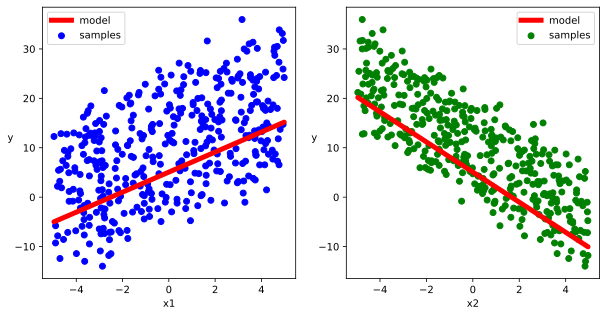

In [231]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.state_dict()["fc.weight"],model.state_dict()["fc.bias"]

plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0,0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

In [232]:
dfhistory.tail()

loss       mae      mape   val_loss   val_mae  val_mape
0  41.778765  6.120908  1.684691  37.834273  5.858693  1.669208
1  38.131506  5.829662  1.662861  34.837392  5.592370  1.625018
2  34.952195  5.557242  1.621901  32.034394  5.330642  1.561949
3  32.138490  5.300226  1.572403  29.390817  5.071779  1.492181
4  29.452922  5.042286  1.500895  26.832951  4.819894  1.408877

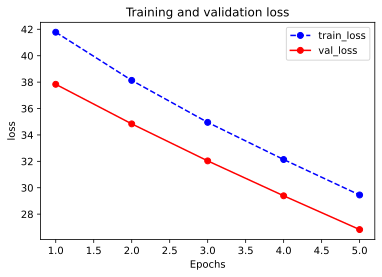

In [233]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(dfhistory,"loss")

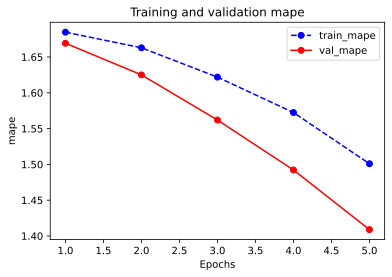

In [234]:
plot_metric(dfhistory,"mape")

In [235]:
# 评估
model.evaluate(dl_valid)

{'val_loss': 26.83295138676961,
 'val_mae': 4.8198936978975935,
 'val_mape': 1.4088771094878514}

#### predict

In [236]:
# 预测
dl = DataLoader(TensorDataset(X))
model.predict(dl)[0:10]

tensor([[-5.3906],
        [ 7.4263],
        [21.0415],
        [11.1305],
        [ 9.9594],
        [ 5.0124],
        [ 3.8061],
        [20.5695],
        [26.1988],
        [ 7.9458]])

In [237]:
# 预测
model.predict(dl_valid)[0:10]

tensor([[ 8.1500],
        [10.7745],
        [-5.3906],
        [ 2.2753],
        [-1.5528],
        [ 3.3744],
        [10.2465],
        [ 0.8095],
        [ 7.1223],
        [28.2268]])

### MLP classification example

In [238]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchkeras

#### data

In [239]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#正负样本数量
n_positive,n_negative = 2000,2000
#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1])
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p) 
#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1])
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n) 
#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0) 
#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

#### dataloader

In [240]:
ds = TensorDataset(X,Y)
ds_train,ds_valid = torch.utils.data.random_split(ds, [int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 100,shuffle=True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 100,num_workers=2)

#### model

In [241]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8)
        self.fc3 = nn.Linear(8,1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y
model = torchkeras.Model(Net())
model.summary(input_shape =(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------


#### train

In [242]:
# 准确率
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                         torch.zeros_like(y_pred,dtype = torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc
model.compile(loss_func = nn.BCELoss(),optimizer= torch.optim.Adam(model.parameters(),lr = 0.01), 
              metrics_dict={"accuracy":accuracy})
dfhistory = model.fit(100,dl_train = dl_train,dl_val = dl_valid,log_step_freq = 10)

Start Training ...

================================================================================2021-08-08 14:58:08
{'step': 10, 'loss': 0.672, 'accuracy': 0.531}
{'step': 20, 'loss': 0.657, 'accuracy': 0.555}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.646 |  0.578   |  0.613   |    0.656     |
+-------+-------+----------+----------+--------------+

================================================================================2021-08-08 14:58:13
{'step': 10, 'loss': 0.582, 'accuracy': 0.698}
{'step': 20, 'loss': 0.576, 'accuracy': 0.717}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   2   | 0.549 |  0.737   |  0.496   |    0.737     |
+-------+-------+----------+----------+--------------+

====================================

KeyboardInterrupt: 

#### evaluate

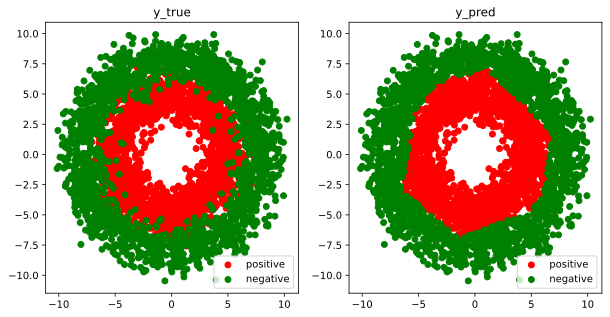

In [243]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (10,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

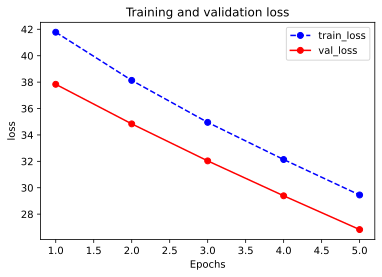

In [244]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(dfhistory,"loss")

In [ ]:
plot_metric(dfhistory,"accuracy")

In [247]:
model.evaluate(dl_valid)

{'val_loss': 0.19551783427596092, 'val_accuracy': 0.9266666571299235}

#### predict

In [248]:
model.predict(dl_valid)[0:10]

tensor([[9.8157e-01],
        [1.1331e-01],
        [9.6961e-01],
        [6.0622e-04],
        [9.6674e-01],
        [7.8154e-01],
        [3.6675e-02],
        [4.0155e-02],
        [2.6304e-02],
        [1.3034e-01]])

### 构建模型的3种方法

可以使用以下3种方式构建模型：
    
    1，继承nn.Module基类构建自定义模型。
    2，使用nn.Sequential按层顺序构建模型。
    3，继承nn.Module基类构建模型并辅助应用模型容器进行封装(nn.Sequential,nn.ModuleList,nn.ModuleDict)。

其中 第1种方式最为常见，第2种方式最简单，第3种方式最为灵活也较为复杂。

推荐使用第1种方式构建模型

In [31]:
import torch
from torch import nn
from torchkeras import summary

#### 继承nn.Module基类构建自定义模型

以下是继承nn.Module基类构建自定义模型的一个范例。模型中的用到的层一般在 __init__ 函
数中定义，然后在 forward 方法中定义模型的正向传播逻辑。

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [33]:
summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

#### 使用nn.Sequential按层顺序构建模型

使用nn.Sequential按层顺序构建模型无需定义forward方法。仅仅适合于简单的模型。

以下是使用nn.Sequential搭建模型的一些等价方法。

##### 利用add_module方法

In [34]:
net = nn.Sequential()
net.add_module("conv1",nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3))
net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("dropout",nn.Dropout2d(p = 0.1))
net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
net.add_module("flatten",nn.Flatten())
net.add_module("linear1",nn.Linear(64,32))
net.add_module("relu",nn.ReLU())
net.add_module("linear2",nn.Linear(32,1))
net.add_module("sigmoid",nn.Sigmoid())
print(net)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


##### 利用变长参数

这种方式构建时不能给每个层指定名称

In [35]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3),
    nn.MaxPool2d(kernel_size = 2,stride = 2),
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
    nn.MaxPool2d(kernel_size = 2,stride = 2),
    nn.Dropout2d(p = 0.1),
    nn.AdaptiveMaxPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,1),
    nn.Sigmoid()
)
print(net)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout2d(p=0.1, inplace=False)
  (5): AdaptiveMaxPool2d(output_size=(1, 1))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=64, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=1, bias=True)
  (10): Sigmoid()
)


##### 利用OrderedDict

In [36]:
from collections import OrderedDict
net = nn.Sequential(OrderedDict(
    [("conv1",nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)),
    ("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)),
    ("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)),
    ("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2)),
    ("dropout",nn.Dropout2d(p = 0.1)),
    ("adaptive_pool",nn.AdaptiveMaxPool2d((1,1))),
    ("flatten",nn.Flatten()),
    ("linear1",nn.Linear(64,32)),
    ("relu",nn.ReLU()),
    ("linear2",nn.Linear(32,1)),
    ("sigmoid",nn.Sigmoid())
    ])
 )
print(net)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [37]:
summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

#### 继承nn.Module基类构建模型并辅助应用模型容器进行封装

当模型的结构比较复杂时，我们可以应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)对模型的部分结构进行封装。

这样做会让模型整体更加有层次感，有时候也能减少代码量。

注意，在下面的范例中我们每次仅仅使用一种模型容器，但实际上这些模型容器的使用是非常灵
活的，可以在一个模型中任意组合任意嵌套使用。

##### nn.Sequential作为模型容器

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1))
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.conv(x)
        y = self.dense(x)
        return y
net = Net()
print(net)

Net(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
  )
  (dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


##### nn.ModuleList作为模型容器

注意下面中的ModuleList不能用Python中的List代替

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1),
            nn.Sigmoid()
        ])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
net = Net()
print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [41]:
summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

##### nn.ModuleDict作为模型容器

注意下面中的ModuleDict不能用Python中的Dict代替

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers_dict =nn.ModuleDict({
        "conv1":nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3),
        "pool": nn.MaxPool2d(kernel_size = 2,stride = 2),
        "conv2":nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
        "dropout": nn.Dropout2d(p = 0.1),
        "adaptive":nn.AdaptiveMaxPool2d((1,1)),
        "flatten": nn.Flatten(),
        "linear1": nn.Linear(64,32),
        "relu":nn.ReLU(),
        "linear2": nn.Linear(32,1),
        "sigmoid": nn.Sigmoid()
        })
    def forward(self,x):
        layers = ["conv1","pool","conv2","pool","dropout","adaptive","flatten","linear1","relu","linear2","sigmoid"]
        for layer in layers:
            x = self.layers_dict[layer](x)
        return x
net = Net()
print(net)

Net(
  (layers_dict): ModuleDict(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (dropout): Dropout2d(p=0.1, inplace=False)
    (adaptive): AdaptiveMaxPool2d(output_size=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)


In [43]:
summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

### 训练模型的3种方法

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：

    脚本形式训练循环
    函数形式训练循环
    类形式训练循环

下面以minist数据集的分类模型的训练为例，演示这3种训练模型的风格。

其中类形式训练循环我们会使用torchkeras.Model和torchkeras.LightModel这两种方法。

#### 准备数据

In [44]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

In [46]:
transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="D:/kwCodes/data/",train=True,download=False,transform=transform)
ds_valid = torchvision.datasets.MNIST(root="D:/kwCodes/data/",train=False,download=False,transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=128, shuffle=False)
print(len(ds_train))
print(len(ds_valid))

60000
10000


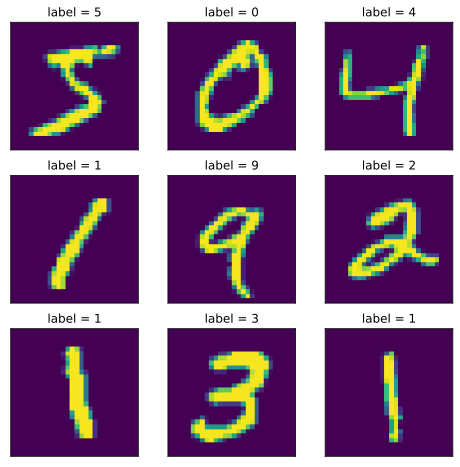

In [47]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#查看部分样本
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
for i in range(9):
    img,label = ds_train[i]
    img = torch.squeeze(img)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#### 脚本风格

脚本风格的训练循环最为常见

In [48]:
net = nn.Sequential()
net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("dropout",nn.Dropout2d(p = 0.1))
net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
net.add_module("flatten",nn.Flatten())
net.add_module("linear1",nn.Linear(64,32))
net.add_module("relu",nn.ReLU())
net.add_module("linear2",nn.Linear(32,10))
print(net)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)


In [49]:
summary(net,input_shape=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [51]:
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true,y_pred_cls)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(),lr = 0.01)
metric_func = accuracy
metric_name = "accuracy"

In [52]:
epochs = 3
log_step_freq = 100

dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name])
print("Start Training...")

nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(1,epochs+1): 
    # 1，训练循环-------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features,labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions,labels)
        metric = metric_func(predictions,labels)
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0: 
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") % 
                  (step, loss_sum/step, metric_sum/step))
    # 2，验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features,labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions,labels)
            val_metric = metric_func(predictions,labels)

        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + " = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
print('Finished Training...')

Start Training...
================================================================================2021-08-09 16:34:16
[step = 100] loss: 0.803, accuracy: 0.725
[step = 200] loss: 0.504, accuracy: 0.830
[step = 300] loss: 0.390, accuracy: 0.871
[step = 400] loss: 0.328, accuracy: 0.892

EPOCH = 1, loss = 0.300,accuracy = 0.902, val_loss = 0.124, val_accuracy = 0.960

================================================================================2021-08-09 16:35:13
[step = 100] loss: 0.113, accuracy: 0.966
[step = 200] loss: 0.114, accuracy: 0.965
[step = 300] loss: 0.110, accuracy: 0.967
[step = 400] loss: 0.109, accuracy: 0.967

EPOCH = 2, loss = 0.109,accuracy = 0.967, val_loss = 0.074, val_accuracy = 0.977

================================================================================2021-08-09 16:36:15
[step = 100] loss: 0.090, accuracy: 0.972
[step = 200] loss: 0.088, accuracy: 0.972
[step = 300] loss: 0.087, accuracy: 0.973
[step = 400] loss: 0.091, accuracy: 0.972

EPOCH = 3, 

#### 函数风格

该风格在脚本形式上作了简单的函数封装

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)
        ])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
net = Net()
print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [54]:
summary(net,input_shape=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [55]:
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true,y_pred_cls)

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = nn.CrossEntropyLoss()
model.metric_func = accuracy
model.metric_name = "accuracy"

In [56]:
def train_step(model,features,labels):
    # 训练模式，dropout层发生作用
    model.train()
    # 梯度清零
    model.optimizer.zero_grad()
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()
    return loss.item(),metric.item()

@torch.no_grad()
def valid_step(model,features,labels):
    # 预测模式，dropout层不发生作用
    model.eval()
    
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()

# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)

(2.3133468627929688, 0.09375)

In [57]:
def train_model(model,epochs,dl_train,dl_valid,log_step_freq):
    metric_name = model.metric_name
    
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name])
    print("Start Training...")
    
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)
    
    for epoch in range(1,epochs+1): 
        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1
        
        for step, (features,labels) in enumerate(dl_train, 1):
            loss,metric = train_step(model,features,labels)
            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0: 
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") % 
                      (step, loss_sum/step, metric_sum/step))
        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features,labels) in enumerate(dl_valid, 1):
            val_loss,val_metric = valid_step(model,features,labels)
            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + " = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)
    print('Finished Training...')
    return dfhistory

In [58]:
epochs = 3
dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 100)

Start Training...
================================================================================2021-08-09 16:42:47
[step = 100] loss: 2.296, accuracy: 0.146
[step = 200] loss: 2.282, accuracy: 0.203
[step = 300] loss: 2.266, accuracy: 0.243
[step = 400] loss: 2.247, accuracy: 0.275

EPOCH = 1, loss = 2.229,accuracy = 0.292, val_loss = 2.080, val_accuracy = 0.503

================================================================================2021-08-09 16:43:47
[step = 100] loss: 2.033, accuracy: 0.427
[step = 200] loss: 1.958, accuracy: 0.448
[step = 300] loss: 1.866, accuracy: 0.473
[step = 400] loss: 1.768, accuracy: 0.500

EPOCH = 2, loss = 1.699,accuracy = 0.518, val_loss = 1.129, val_accuracy = 0.751

================================================================================2021-08-09 16:44:50
[step = 100] loss: 1.159, accuracy: 0.662
[step = 200] loss: 1.080, accuracy: 0.682
[step = 300] loss: 1.009, accuracy: 0.701
[step = 400] loss: 0.951, accuracy: 0.719

EPOCH = 3, 

#### 类风格 torchkeras.Model

此处使用torchkeras.Model构建模型，并调用compile方法和fit方法训练模型。
使用该形式训练模型非常简洁明了

In [59]:
import torchkeras
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)
        ])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
model = torchkeras.Model(CnnModel())
print(model)

Model(
  (net): CnnModel(
    (layers): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): AdaptiveMaxPool2d(output_size=(1, 1))
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=64, out_features=32, bias=True)
      (8): ReLU()
      (9): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)


In [60]:
model.summary(input_shape=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [61]:
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true.numpy(),y_pred_cls.numpy())

model.compile(loss_func = nn.CrossEntropyLoss(),optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
              metrics_dict={"accuracy":accuracy})
dfhistory = model.fit(3,dl_train = dl_train, dl_val=dl_valid, log_step_freq=100)

Start Training ...

================================================================================2021-08-09 16:48:31
{'step': 100, 'loss': 0.771, 'accuracy': 0.733}
{'step': 200, 'loss': 0.498, 'accuracy': 0.832}
{'step': 300, 'loss': 0.409, 'accuracy': 0.865}
{'step': 400, 'loss': 0.348, 'accuracy': 0.887}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.321 |  0.896   |   0.09   |    0.973     |
+-------+-------+----------+----------+--------------+

================================================================================2021-08-09 16:49:31
{'step': 100, 'loss': 0.183, 'accuracy': 0.948}
{'step': 200, 'loss': 0.179, 'accuracy': 0.95}
{'step': 300, 'loss': 0.18, 'accuracy': 0.95}
{'step': 400, 'loss': 0.178, 'accuracy': 0.951}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+

#### 类风格 torchkeras.LightModel

下面示范torchkeras.LightModel的使用范例，详细用法可以参照

In [62]:
import torchkeras
import pytorch_lightning as pl

In [63]:
class CnnNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)
        ])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
class Model(torchkeras.LightModel):
    #loss,and optional metrics
    def shared_step(self,batch)->dict:
        x, y = batch
        prediction = self(x)
        loss = nn.CrossEntropyLoss()(prediction,y)
        preds = torch.argmax(nn.Softmax(dim=1)(prediction),dim=1).data
        acc = pl.metrics.functional.accuracy(preds, y)
        dic = {"loss":loss,"acc":acc}
        return dic
    #optimizer,and optional lr_scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)
        return {"optimizer":optimizer,"lr_scheduler":lr_scheduler}

pl.seed_everything(1234)
net = CnnNet()
model = Model(net)

torchkeras.summary(model,input_shape=(1,32,32))
print(model)

Global seed set to 1234


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [ ]:
ckpt_cb = pl.callbacks.ModelCheckpoint(monitor='val_loss')
# set gpus=0 will use cpu，
# set gpus=1 will use 1 gpu
# set gpus=2 will use 2gpus 
# set gpus = -1 will use all gpus 
# you can also set gpus = [0,1] to use the given gpus
# you can even set tpu_cores=2 to use two tpus 
trainer = pl.Trainer(max_epochs=3, callbacks=[ckpt_cb])
trainer.fit(model,dl_train,dl_valid)

### 使用GPU训练模型

#### torch_cuda基本操作

深度学习的训练过程常常非常耗时，一个模型训练几个小时是家常便饭，训练几天也是常有的事
情，有时候甚至要训练几十天。

训练过程的耗时主要来自于两个部分，一部分来自数据准备，另一部分来自参数迭代。

当数据准备过程还是模型训练时间的主要瓶颈时，我们可以使用更多进程来准备数据。

当参数迭代过程成为训练时间的主要瓶颈时，我们通常的方法是应用GPU来进行加速。

Pytorch中使用GPU加速模型非常简单，只要将模型和数据移动到GPU上。核心代码只有以下几
行。

In [ ]:
# 定义模型
...
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) # 移动模型到cuda
# 训练模型
...
features = features.to(device) # 移动数据到cuda
labels = labels.to(device) # 或者 labels = labels.cuda() if 
torch.cuda.is_available() else labels
...

如果要使用多个GPU训练模型，也非常简单。只需要在将模型设置为数据并行风格模型。 则模
型移动到GPU上之后，会在每一个GPU上拷贝一个副本，并把数据平分到各个GPU上进行训练。
核心代码如下。

In [ ]:
# 定义模型
...
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model) # 包装为并行风格模型
# 训练模型
...
features = features.to(device) # 移动数据到cuda
labels = labels.to(device) # 或者 labels = labels.cuda() if 
torch.cuda.is_available() else labels
...

In [69]:
import torch
from torch import nn
# 1，查看gpu信息
if_cuda = torch.cuda.is_available()
print("if_cuda=",if_cuda)
gpu_count = torch.cuda.device_count()
print("gpu_count=",gpu_count)

if_cuda= False
gpu_count= 0


In [ ]:
# 2，将张量在gpu和cpu间移动
tensor = torch.rand((100,100))
tensor_gpu = tensor.to("cuda:0") # 或者 tensor_gpu = tensor.cuda()
print(tensor_gpu.device)
print(tensor_gpu.is_cuda)

tensor_cpu = tensor_gpu.to("cpu") # 或者 tensor_cpu = tensor_gpu.cpu() 
print(tensor_cpu.device)

In [ ]:
# 3，将模型中的全部张量移动到gpu上
net = nn.Linear(2,1)
print(next(net.parameters()).is_cuda)
net.to("cuda:0") # 将模型中的全部参数张量依次到GPU上，注意，无需重新赋值为 net = 
net.to("cuda:0")
print(next(net.parameters()).is_cuda)
print(next(net.parameters()).device)

In [ ]:
# 4，创建支持多个gpu数据并行的模型
linear = nn.Linear(2,1)
print(next(linear.parameters()).device)

model = nn.DataParallel(linear)
print(model.device_ids)
print(next(model.module.parameters()).device) 

#注意保存参数时要指定保存model.module的参数
torch.save(model.module.state_dict(), "./saved_model/model_parameter.pkl")
linear = nn.Linear(2,1)
linear.load_state_dict(torch.load("./saved_model/model_parameter.pkl"))

In [ ]:
# 5，清空cuda缓存

# 该方法在cuda超内存时十分有用
torch.cuda.empty_cache()

#### 矩阵乘法范例

下面分别使用CPU和GPU作一个矩阵乘法，并比较其计算效率

In [71]:
import time
import torch
from torch import nn

In [72]:
# 使用cpu
a = torch.rand((10000,200))
b = torch.rand((200,10000))
tic = time.time()
c = torch.matmul(a,b)
toc = time.time()
print(toc-tic)
print(a.device)
print(b.device)

0.8372237682342529
cpu
cpu


In [ ]:
# 使用gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") a = torch.rand((10000,200),device = device) #可以指定在GPU上创建张量
b = torch.rand((200,10000)) #也可以在CPU上创建张量后移动到GPU上 b = b.to(device) #或者 b = b.cuda() if torch.cuda.is_available() else b 
tic = time.time()
c = torch.matmul(a,b)
toc = time.time()
print(toc-tic)
print(a.device)
print(b.device)

结果应当是
    
    0.014541149139404297
    cuda:0
    cuda:0

#### 线性回归范例

下面对比使用CPU和GPU训练一个线性回归模型的效率

##### cpu_version

In [73]:
# 准备数据
n = 1000000 #样本数量
X = 10*torch.rand([n,2])-5.0 #torch.rand是均匀分布
w0 = torch.tensor([[2.0,-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0.t() + b0 + torch.normal( 0.0,2.0,size = [n,1]) # @表示矩阵乘法,增加正态扰动
# 定义模型
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn_like(w0))
        self.b = nn.Parameter(torch.zeros_like(b0))
    #正向传播
    def forward(self,x):
        return x@self.w.t() + self.b

linear = LinearRegression()

# 训练模型
optimizer = torch.optim.Adam(linear.parameters(),lr = 0.1)
loss_func = nn.MSELoss()
def train(epoches):
    tic = time.time()
    for epoch in range(epoches):
        optimizer.zero_grad()
        Y_pred = linear(X)
        loss = loss_func(Y_pred,Y)
        loss.backward()
        optimizer.step()
        if epoch%100==0:
            print({"epoch":epoch,"loss":loss.item()})
    toc = time.time()
    print("time used:",toc-tic)

train(500)

{'epoch': 0, 'loss': 208.26358032226562}
{'epoch': 100, 'loss': 9.03459358215332}
{'epoch': 200, 'loss': 4.018596649169922}
{'epoch': 300, 'loss': 3.994361400604248}
{'epoch': 400, 'loss': 3.994358539581299}
time used: 6.373887300491333


##### gpu_version

In [ ]:
# 准备数据
n = 1000000 #样本数量
X = 10*torch.rand([n,2])-5.0 #torch.rand是均匀分布
w0 = torch.tensor([[2.0,-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0.t() + b0 + torch.normal( 0.0,2.0,size = [n,1]) # @表示矩阵乘法,增加正态扰动

# 移动到GPU上
print("torch.cuda.is_available() = ",torch.cuda.is_available())
X = X.cuda()
Y = Y.cuda()
print("X.device:",X.device)
print("Y.device:",Y.device)

In [ ]:
# 定义模型
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn_like(w0))
        self.b = nn.Parameter(torch.zeros_like(b0))
    #正向传播
    def forward(self,x):
        return x@self.w.t() + self.b

linear = LinearRegression()

# 移动模型到GPU上
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
linear.to(device) 

#查看模型是否已经移动到GPU上
print("if on cuda:",next(linear.parameters()).is_cuda)

In [ ]:
# 训练模型
optimizer = torch.optim.Adam(linear.parameters(),lr = 0.1)
loss_func = nn.MSELoss()
def train(epoches):
    tic = time.time()
    for epoch in range(epoches):
        optimizer.zero_grad()
        Y_pred = linear(X)
        loss = loss_func(Y_pred,Y)
        loss.backward()
        optimizer.step()
        if epoch%100==0:
            print({"epoch":epoch,"loss":loss.item()})
    toc = time.time()
    print("time used:",toc-tic)
train(500)

这里的time_use应该是 0.50左右，快了很多

#### torchkeras.Model使用单GPU范例

下面演示使用torchkeras.Model来应用GPU训练模型的方法。

其对应的CPU训练模型代码参见《6-2,训练模型的3种方法》

本例仅需要在它的基础上增加一行代码，在model.compile时指定 device即可

##### data

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchkeras

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="./data/minist/",train=True,download=True,transform=transform)
ds_valid = torchvision.datasets.MNIST(root="./data/minist/",train=False,download=True,transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=128, shuffle=False)
print(len(ds_train))
print(len(ds_valid))

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#查看部分样本
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
for i in range(9):
    img,label = ds_train[i]
    img = torch.squeeze(img)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

##### model

In [ ]:
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)
        ])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

net = CnnModel()
model = torchkeras.Model(net)
model.summary(input_shape=(1,32,32))

##### train

In [ ]:
from sklearn.metrics import accuracy_score
def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true.cpu().numpy(),y_pred_cls.cpu().numpy())
    # 注意此处要将数据先移动到cpu上，然后才能转换成numpy数组

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.compile(loss_func = nn.CrossEntropyLoss(),optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
              metrics_dict={"accuracy":accuracy},device = device) 
# 注意此处compile时指定了device
dfhistory = model.fit(3,dl_train = dl_train, dl_val=dl_valid, log_step_freq=100)

##### evaluate

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"accuracy")
model.evaluate(dl_valid)

##### predict

In [ ]:
model.predict(dl_valid)[0:10]

##### save model

In [ ]:
# save the model parameters
torch.save(model.state_dict(), "model_parameter.pkl")
model_clone = torchkeras.Model(CnnModel())
model_clone.load_state_dict(torch.load("model_parameter.pkl"))
model_clone.compile(loss_func = nn.CrossEntropyLoss(),optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
                    metrics_dict={"accuracy":accuracy},device = device) # 注意此处compile时指定了device
model_clone.evaluate(dl_valid)

#### torchkeras.Model使用多GPU范例

以下范例需要在有多个GPU的机器上跑。如果在单GPU的机器上跑，也能跑通，但是实际上使用的是单个GPU

##### data

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchkeras

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="./data/minist/",train=True,download=True,transform=transform)
ds_valid = torchvision.datasets.MNIST(root="./data/minist/",train=False,download=True,transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=128, shuffle=False)
print(len(ds_train))
print(len(ds_valid))

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#查看部分样本
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
for i in range(9):
    img,label = ds_train[i]
    img = torch.squeeze(img)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

##### model

In [ ]:
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)
        ])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
'''torch只需一行就可以多卡'''
net = nn.DataParallel(CnnModule()) #Attention this line!!!
model = torchkeras.Model(net)
model.summary(input_shape=(1,32,32))

##### train

In [ ]:
from sklearn.metrics import accuracy_score
def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true.cpu().numpy(),y_pred_cls.cpu().numpy())
    # 注意此处要将数据先移动到cpu上，然后才能转换成numpy数组

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.compile(loss_func = nn.CrossEntropyLoss(),optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
              metrics_dict={"accuracy":accuracy},device = device) 
# 注意此处compile时指定了device
dfhistory = model.fit(3,dl_train = dl_train, dl_val=dl_valid, log_step_freq=100)

##### evaluate

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"accuracy")
model.evaluate(dl_valid)

##### predict

In [ ]:
model.predict(dl_valid)[0:10]

##### save model

In [ ]:
# save the model parameters
torch.save(model.state_dict(), "model_parameter.pkl")
model_clone = torchkeras.Model(CnnModel())
model_clone.load_state_dict(torch.load("model_parameter.pkl"))
model_clone.compile(loss_func = nn.CrossEntropyLoss(),optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
                    metrics_dict={"accuracy":accuracy},device = device) # 注意此处compile时指定了device
model_clone.evaluate(dl_valid)

#### torchkeras.LightModel使用GPU/TPU范例

使用torchkeras.LightModel可以非常容易地将训练模式从cpu切换到单个gpu，多个gpu乃至多个
tpu.

##### data

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchkeras

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="./data/minist/",train=True,download=True,transform=transform)
ds_valid = torchvision.datasets.MNIST(root="./data/minist/",train=False,download=True,transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=128, shuffle=False)
print(len(ds_train))
print(len(ds_valid))

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#查看部分样本
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
for i in range(9):
    img,label = ds_train[i]
    img = torch.squeeze(img)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

##### model

In [ ]:
import torchkeras
import pytorch_lightning as pl

class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)
        ])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

class Model(torchkeras.LightModel):
    #loss,and optional metrics
    def shared_step(self,batch)->dict:
        x, y = batch
        prediction = self(x)
        loss = nn.CrossEntropyLoss()(prediction,y)
        preds = torch.argmax(nn.Softmax(dim=1)(prediction),dim=1).data
        acc = pl.metrics.functional.accuracy(preds, y)
        dic = {"loss":loss,"acc":acc}
        return dic
    
    #optimizer,and optional lr_scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)
        return {"optimizer":optimizer,"lr_scheduler":lr_scheduler}

pl.seed_everything(1234)
net = CnnNet()
model = Model(net)

torchkeras.summary(model,input_shape=(1,32,32))
print(model)

##### train

In [ ]:
ckpt_cb = pl.callbacks.ModelCheckpoint(monitor='val_loss')
# set gpus=0 will use cpu，
# set gpus=1 will use 1 gpu
# set gpus=2 will use 2gpus 
# set gpus = -1 will use all gpus 
# you can also set gpus = [0,1] to use the given gpus
# you can even set tpu_cores=2 to use two tpus 
trainer = pl.Trainer(max_epochs=10,gpus = 2, callbacks=[ckpt_cb])
trainer.fit(model,dl_train,dl_valid)

##### evaluate

In [ ]:
import pandas as pd
history = model.history
dfhistory = pd.DataFrame(history)
print(dfhistory)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"accuracy")
results = trainer.test(model, test_dataloaders=dl_valid, verbose = False)
print(results[0])

##### predict

In [ ]:
def predict(model,dl):
    model.eval()
    preds = torch.cat([model.forward(t[0].to(model.device)) for t in dl])
    result = torch.argmax(nn.Softmax(dim=1)(preds),dim=1).data
    return(result.data)

result = predict(model,dl_valid)
result

##### save model

In [ ]:
print(ckpt_cb.best_model_score)
model.load_from_checkpoint(ckpt_cb.best_model_path)
best_net = model.net
torch.save(best_net.state_dict(),"./data/net.pt")
net_clone = CnnNet()
net_clone.load_state_dict(torch.load("./data/net.pt"))
model_clone = Model(net_clone)
trainer = pl.Trainer()
result = trainer.test(model_clone,test_dataloaders=dl_valid, verbose = False)
print(result)

## others